# 8주차 과제 - 개인 프로젝트 (2주간 진행)

## 목표
- 주어진 데이터셋 중 원하는 데이터셋을 사용해 원하는 사전 훈련 모델(CNN)을 훈련시키고, 연구보고서를 작성해 보세요.

## 조건
- Test Accuracy, Test Loss 출력 값과 성능 시각화(그래프)를 포함한 연구 및 분석 과정에 대한 내용이 있어야합니다.
- 위 성공 조건을 달성했다면. 실제 데이터를 입력해 예측 또는 분류 결과 출력 후 분석한 내용도 작성해보세요.
- 학습 기록을 RDB나 NoSQL에 저장해보세요. (에포크 번호, 학습 시작 시각, 학습 종료 시각, 학습 결과 손실 함수값과 정확도 등)
- 저장된 학습 기록을 조회하는 쿼리를 작성해보세요.


# Summary
## 사용한 데이터셋
- 데이터셋 : [Flowers Dataset(Kaggle)](https://www.kaggle.com/datasets/imsparsh/flowers-dataset/data)

## 적용한 기술 스택
- 구글 드라이브 마운트 및 File I/O
    - 모델 파라미터 저장(.pth)
    - kaggle.json 파일 업로드 및 저장 처리
- RDB 사용
    - Aiven MySQL 사용
    - 모델 리스트, 학습 이력, 검사 이력 저장
- kaggle CLI 사용
    - kaggle 데이터 다운로드 및 압축 해제

# 0. 필요한 추가 라이브러리 설치 및 필요 모듈 Importing
- Optuna 설치 (하이퍼 파라미터 최적화)
- SQL Alchemy 설치 (MySQL 제어)
- 필요한 모듈 Importing (google.colab, torch, etc)


In [24]:
!pip install optuna
!pip install pymysql sqlalchemy

In [25]:
# Google Colab
from google.colab import drive, files

# 시스템 명령 & 파일 처리
import os
import shutil

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

# torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.models import (
    VGG16_Weights,
    ResNet50_Weights,
    ResNeXt50_32X4D_Weights
)

# hugging face timm
import timm

# Garbage Collector
import gc

# Python의 반복문에 진행상황을 시각적으로 보여주는 라이브러리
from tqdm import tqdm

# 데이터 분석 및 시각화
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 이미지 처리
from PIL import Image

from datetime import datetime
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import optuna

## 0-2. 로깅 함수 정의
- 화면 출력 용

In [26]:
class Logger:
    def __init__(self, name):
        self.name = name

    def log(self, message):
        now = datetime.now()
        date = now.strftime('%Y-%m-%d')
        time = now.strftime('%H:%M:%S.') + f'{int(now.microsecond / 1000):03d}'
        if self.name:
            print(f"[{date} {time}] [{self.name}] {message}")
        else:
            print(f"[{date} {time}] {message}")

    def __call__(self, message):
        self.log(message)

## 0-3. 데이터베이스 처리 모듈 정의
- 각 테이블 조작 (Repository Pattern)

In [27]:
# 데이터베이스 처리 모듈
# 학습 로그 (모델별 에포크당 학습 Loss, Accuracy, 검증 Loss, Accuracy, 기록 시간)
# 검사 이력 (모델별 이미지 파일명(또는 경로), 실제 값, 예측 값, 기록 시간)

# 데이터베이스 설계
# Models Table
#   - model_id
#   - model_name

# Training Table
#   - training_id
#   - training_datetime
#   - model_id (Foreign Key)

# Training Logs Table
#   - training_log_id
#   - training_id (Foreign Key)
#   - epoch
#   - start_datetime
#   - end_datetime
#   - training_loss
#   - training_accuracy
#   - validation_loss
#   - validation_accuracy

# Test Table
#   - test_id
#   - test_name
#   - model_id (Foreign Key)

# Test Logs Table
#   - test_log_id
#   - test_id (Foreign Key)
#   - image
#   - real_class
#   - pred_class

import pymysql
from sqlalchemy import create_engine, text
from datetime import datetime

class MysqlClient:
    def __init__(self, host, port, user, password, db):
        self.engine = create_engine(
            f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}",
            echo=False,
            future=True
        )
        self._create_tables_if_not_exist()

    def _create_tables_if_not_exist(self):
        with self.engine.begin() as conn:
            conn.execute(text("""
                CREATE TABLE IF NOT EXISTS Models (
                    model_id INT AUTO_INCREMENT PRIMARY KEY,
                    model_name VARCHAR(255) UNIQUE NOT NULL
                );
            """))
            conn.execute(text("""
                CREATE TABLE IF NOT EXISTS Training (
                    training_id INT AUTO_INCREMENT PRIMARY KEY,
                    training_datetime DATETIME DEFAULT CURRENT_TIMESTAMP,
                    model_id INT,
                    FOREIGN KEY (model_id) REFERENCES Models(model_id)
                );
            """))
            conn.execute(text("""
                CREATE TABLE IF NOT EXISTS TrainingLogs (
                    training_log_id INT AUTO_INCREMENT PRIMARY KEY,
                    training_id INT,
                    epoch INT,
                    start_datetime DATETIME,
                    end_datetime DATETIME,
                    training_loss FLOAT,
                    training_accuracy FLOAT,
                    validation_loss FLOAT,
                    validation_accuracy FLOAT,
                    FOREIGN KEY (training_id) REFERENCES Training(training_id)
                );
            """))
            conn.execute(text("""
                CREATE TABLE IF NOT EXISTS Test (
                    test_id INT AUTO_INCREMENT PRIMARY KEY,
                    test_name VARCHAR(255),
                    model_id INT,
                    FOREIGN KEY (model_id) REFERENCES Models(model_id)
                );
            """))
            conn.execute(text("""
                CREATE TABLE IF NOT EXISTS TestLogs (
                    test_log_id INT AUTO_INCREMENT PRIMARY KEY,
                    test_id INT,
                    image VARCHAR(512),
                    real_class VARCHAR(128),
                    pred_class VARCHAR(128),
                    FOREIGN KEY (test_id) REFERENCES Test(test_id)
                );
            """))

    # ========== 모델 관련 ==========
    def get_or_create_model(self, model_name):
        with self.engine.begin() as conn:
            result = conn.execute(text("SELECT model_id FROM Models WHERE model_name = :model_name"),
                                  {"model_name": model_name}).fetchone()
            if result:
                return result[0]
            conn.execute(text("INSERT INTO Models (model_name) VALUES (:model_name)"),
                         {"model_name": model_name})
            return conn.execute(text("SELECT LAST_INSERT_ID()")).scalar()

    # ========== 학습 기록 ==========
    def create_training(self, model_name):
        model_id = self.get_or_create_model(model_name)
        with self.engine.begin() as conn:
            result = conn.execute(
                text("INSERT INTO Training (model_id) VALUES (:model_id)"),
                {"model_id": model_id}
            )
            training_id = conn.execute(text("SELECT LAST_INSERT_ID()")).scalar()
            return training_id

    def insert_training_log(self, training_id, epoch, start_dt, end_dt,
                            train_loss, train_acc, val_loss, val_acc):
        with self.engine.begin() as conn:
            conn.execute(text("""
                INSERT INTO TrainingLogs (training_id, epoch, start_datetime, end_datetime,
                                          training_loss, training_accuracy,
                                          validation_loss, validation_accuracy)
                VALUES (:training_id, :epoch, :start_dt, :end_dt,
                        :train_loss, :train_acc, :val_loss, :val_acc)
            """), {
                "training_id": training_id,
                "epoch": epoch,
                "start_dt": start_dt,
                "end_dt": end_dt,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

    def get_training_logs(self, training_id):
        with self.engine.begin() as conn:
            result = conn.execute(text("""
                SELECT * FROM TrainingLogs WHERE training_id = :training_id
            """), {"training_id": training_id}).fetchall()
            return result

    # ========== 테스트 기록 ==========
    def create_test(self, model_name, test_name):
        model_id = self.get_or_create_model(model_name)
        with self.engine.begin() as conn:
            result = conn.execute(
                text("INSERT INTO Test (test_name, model_id) VALUES (:test_name, :model_id)"),
                {"test_name": test_name, "model_id": model_id}
            )
            test_id = conn.execute(text("SELECT LAST_INSERT_ID()")).scalar()
            return test_id

    def insert_test_log(self, test_id, image, real_class, pred_class):
        with self.engine.begin() as conn:
            conn.execute(text("""
                INSERT INTO TestLogs (test_id, image, real_class, pred_class)
                VALUES (:test_id, :image, :real_class, :pred_class)
            """), {
                "test_id": test_id,
                "image": image,
                "real_class": real_class,
                "pred_class": pred_class
            })

    def get_test_logs(self, test_id):
        with self.engine.begin() as conn:
            result = conn.execute(text("SELECT * FROM TestLogs WHERE test_id = :test_id"),
                                  {"test_id": test_id}).fetchall()
            return result

    # 모델 없으면 삽입, 있으면 무시
    def add_model_if_not_exists(self, model_name):
        with self.engine.begin() as conn:
            result = conn.execute(text("SELECT model_id FROM Models WHERE model_name = :model_name"),
                                  {"model_name": model_name}).fetchone()
            if not result:
                conn.execute(text("INSERT INTO Models (model_name) VALUES (:model_name)"),
                             {"model_name": model_name})
                print(f"[INFO] 모델 '{model_name}' 새로 추가됨.")
            else:
                print(f"[INFO] 모델 '{model_name}' 이미 존재함. 추가하지 않음.")

    # 모델 목록 조회 및 출력
    def list_models(self):
        with self.engine.begin() as conn:
            result = conn.execute(text("SELECT model_id, model_name FROM Models")).fetchall()
            if not result:
                print("[INFO] 등록된 모델이 없습니다.")
            else:
                print("[모델 목록]")
                for row in result:
                    print(f" - ID: {row.model_id}, Name: {row.model_name}")
            return result

from google.colab import userdata
mysql_pw = userdata.get('MYSQL_PW')

client = MysqlClient(
    host = 'ybkim-mysql-ybkim-test.h.aivencloud.com',
    port = 19485,
    user = 'avnadmin',
    password = mysql_pw,
    db = 'defaultdb'
)

client.add_model_if_not_exists("vgg16")
client.list_models()

[INFO] 모델 'vgg16' 이미 존재함. 추가하지 않음.
[모델 목록]
 - ID: 4, Name: convnext_tiny
 - ID: 2, Name: resnet50
 - ID: 6, Name: swinv2_tiny_window8_256
 - ID: 3, Name: tf_efficientnetv2_s
 - ID: 1, Name: vgg16
 - ID: 5, Name: vit_base_patch16_224


[(4, 'convnext_tiny'),
 (2, 'resnet50'),
 (6, 'swinv2_tiny_window8_256'),
 (3, 'tf_efficientnetv2_s'),
 (1, 'vgg16'),
 (5, 'vit_base_patch16_224')]

# 1. 데이터 수집
- kaggle.json 파일이 있어야 하는 경로에 파일이 없으면
    - Kaggle 파일 업로드 - 구글 드라이브에 파일 올려두고 해당 파일 읽어오기
    - 있으면 그냥 진행
- Kaggle 데이터 수집


In [28]:
# Kaggle 인증 및 데이터 수집
# 드라이브 마운트
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/Colab Notebooks"

# Kaggle 설정 및 데이터 로딩
kaggle_json_dir = os.path.join(base_dir, "Kaggle")
kaggle_json_file_name = "kaggle.json"
kaggle_json_file_path = os.path.join(kaggle_json_dir, kaggle_json_file_name)
kaggle_cli_root_path = "/root/.kaggle"
kaggle_cli_root_path_file = os.path.join(kaggle_cli_root_path, kaggle_json_file_name)
model_save_dir = os.path.join(base_dir, "flower_models")

# 필요한 폴더 생성
## Google Drive
os.makedirs(kaggle_json_dir, exist_ok = True) # kaggle.json 파일 저장 폴더 생성
os.makedirs(model_save_dir, exist_ok = True) # 학습된 모델 저장용 폴더 생성
## Google Colab
### ~/.kaggle 디렉토리 생성 및 이동
### Kaggle CLI는 이 위치에 있는 kaggle.json 파일을 사용하도록 설계되어 있음. (기본 인증 경로)
os.makedirs(kaggle_cli_root_path, exist_ok = True) # kaggle CLI용 kaggle.json 파일 폴더 생성

# kaggle.json을 Google Drive에서 찾고, 있으면 Colab으로 복사, 없으면 업로드.
if os.path.exists(kaggle_json_file_path):
    shutil.copy(kaggle_json_file_path, kaggle_cli_root_path_file)
else:
    files.upload()
    shutil.copy(kaggle_json_file_name, kaggle_json_file_path)

# kaggle.json 파일 권한 설정
# 600 = 해당 파일을 소유한 사용자만 읽고 쓸 수 있도록 설정
os.chmod(kaggle_cli_root_path_file, 600)

# Kaggle 데이터 다운로드
## -d 옵션은 --dataset 이고, 어떤 데이터셋을 받을지 데이터셋의 ID를 지정하는 옵션
!kaggle datasets download -d imsparsh/flowers-dataset

# Kaggle 데이터 압축 해제
## -q : quiet mode (출력 메시지 생략)
## -d : destination directory 지정
!unzip -q flowers-dataset.zip -d flowers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
flowers-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace flowers/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# 2. 모델 별 작업
0. 프로젝트 구조 설계 및 모듈화
    - 모델 클래스화 (모델, 하이퍼 파라미터, 학습 이력 등)
1. 데이터 전처리 (transform 최적화)
    - 모델별 입력 데이터 변환(Transform) 최적화
    - 데이터 분할 (training: 70%, validation: 15%, testing: 15%)

2. 하이퍼파라미터 튜닝 (Optuna 사용)
    - Optuna를 사용하여 Learning Rate, Optimizer, Batch Size 튜닝 수행
    - Optuna 튜닝은 trial = 20, 각 trial당 epoch = 3
    - 튜닝 과정 이력 기록 (RDB)

3. 모델 훈련(학습, 검증) 및 검사(테스트)
    - 모델별 학습 epoch = 10
    - 모델별 학습 이력 기록 (모델 별, Epoch 별, 시작 시간, 종료 시간, Loss, Accuracy)
    - 모델별 테스트 이력 기록 (모델 별, 이미지 별, 분류 소요 시간, 분류 종료 시간, 그 외 평가지표)

## 데이터 관리
- 모든 이력은 RDB로 관리한다.


## 2.0 프로젝트 구조 설계 및 모듈화
- 이미지 분류 모델 클래스 정의
- 튜닝기, 훈련기, 검증기, 검사기를 만들어 역할 분담.
- 각 모델별 데이터 전처리를 위해 DataPreprocessor 개발

### 2.0.1 이미지 분류 클래스 설계


In [29]:
## 이미지 분류 클래스 설계
class ImageClassificationModel:
    """
    모델 이름, 모델, 하이퍼파라미터 등을 저장하는 이미지 분류 모델 클래스
    """
    DEFAULT_LEARNING_RATE = 0.001
    DEFAULT_OPTIMIZER = "Adam"
    DEFAULT_BATCH_SIZE = 32

    def __init__(self, device, model_name:  str, num_classes: int = 5):
        self.device = device

        self.model_name = model_name
        self.num_classes = num_classes
        self.model = None

        self._is_need_to_tuning = True
        self._is_need_to_training = True

        self.learning_rate = ImageClassificationModel.DEFAULT_LEARNING_RATE
        self.optimizer = ImageClassificationModel.DEFAULT_OPTIMIZER
        self.batch_size = ImageClassificationModel.DEFAULT_BATCH_SIZE

        self._logger = Logger(model_name)

        self.train_logs = []
        self.test_logs = []
        self.test_all_preds = []
        self.test_all_targets = []

    def load(self):
        """
        모델 정보를 기반으로 모델을 로딩하고 Classification Layer를 모델별로 수정하여 반환한다.
        """
        self._logger("로딩 시작")

        weights_map = {
            "vgg16": VGG16_Weights.DEFAULT,
            "resnet50": ResNet50_Weights.DEFAULT,
        }

        if self.model_name in ["vgg16", "resnet50"]:
            weights = weights_map.get(self.model_name, None)
            self.model = getattr(torchvision.models, self.model_name)(weights = weights)
            in_features = self.model.classifier[6].in_features if "vgg" in self.model_name else self.model.fc.in_features

            if "vgg" in self.model_name:
                self.model.classifier[6] = nn.Linear(in_features, self.num_classes)
            else:
                self.model.fc = nn.Linear(in_features, self.num_classes)
        else:
            self.model = timm.create_model(self.model_name, pretrained = True, num_classes = self.num_classes)

        self._logger("로딩 완료")

    def update_dataset(self, train_dataset, validation_dataset, test_dataset):
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.test_dataset = test_dataset

    def update_hyperparameters(self, learning_rate: float, optimizer: str, batch_size: int):
        """
        모델의 하이퍼 파라미터를 업데이트한다.
        learning_rate, optimizer, batch_size
        """
        self._logger("Hyperparameter 튜닝 시작")
        self._logger(f"learning_rate = {self.learning_rate} -> {learning_rate}")
        self._logger(f"optimizer = {self.optimizer} -> {optimizer}")
        self._logger(f"_batch_size = {self.batch_size} -> {batch_size}")

        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.batch_size = batch_size

        self._logger("Hyperparameter 튜닝 완료")

    def save(self):
        """
        학습된 모델을 저장한다.
        """
        self._logger("저장 시작")

        model_path = os.path.join(model_save_dir, f"{self.model_name}.pth")
        torch.save(self.model.state_dict(), model_path)
        print(f"[INFO] 모델이 저장됨: {model_path}")

        training_id = client.create_training(self.model_name)
        for log in self.train_logs:
            client.insert_training_log(
                training_id = training_id,
                epoch = log["epoch"],
                start_dt = log["start_time"],
                end_dt = log["end_time"],
                train_loss = log["train_loss"],
                train_acc = log["train_acc"],
                val_loss = log["val_loss"],
                val_acc = log["val_acc"]
            )

        test_id = client.create_test(self.model_name, "test")
        for log in self.test_logs:
            client.insert_test_log(
                test_id = test_id,
                image = log["image"],
                real_class = log["real_class"],
                pred_class = log["pred_class"]
            )

        self._logger("저장 완료")
        pass

    def unload(self):
        """
        모델을 언로딩한다. (메모리 최적화)
        """
        self._logger("언로딩 시작")

        del self.model
        torch.cuda.empty_cache()  # GPU 캐시 정리
        self._logger("Model 제거")

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

        self._logger("데이터셋 제거")

        gc.collect()
        self._logger("Garbage  Collection 실행")

        self._logger("언로딩 완료")
        pass

    def __repr__(self):
        return f"ImageClassificationModel(model_name={self.model_name}, learning_rate={self.learning_rate}, optimizer={self.optimizer}, batch_size={self.batch_size})"

### 2.0.2 데이터 전처리 설계
- 모델별 transform 맞춤
- 데이터셋 분할

In [30]:
def create_transform_for_model(imageClassificationModel: ImageClassificationModel):
    train_transform = None
    val_transform = None
    test_transform = None

    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

    # train, val, Test transform 만들기
    if imageClassificationModel.model_name in ["vgg16", "resnet50"]:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])

        val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])
    elif imageClassificationModel.model_name in ["tf_efficientnetv2_s"]:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(300),
            transforms.RandomHorizontalFlip(),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])

        val_transform = transforms.Compose([
            transforms.Resize(320),
            transforms.CenterCrop(300),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])
    elif imageClassificationModel.model_name in ["convnext_tiny"]:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])

        val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])
    elif imageClassificationModel.model_name in ["swinv2_tiny_window8_256"]:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])
        val_transform = transforms.Compose([
            transforms.Resize(288),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std),
        ])
    elif imageClassificationModel.model_name == "vit_base_patch16_224":
        train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])
        ])
        val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])
        ])
    else:
        raise ValueError(f"지원하지 않는 모델입니다. {imageClassificationModel.model_name}")

    test_transform = val_transform

    return train_transform, val_transform, test_transform

class TransformedSubset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.base_dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

class DataPreprocessor:
    def __init__(self, data_path):
        self.data_path = data_path
        pass

    def split(self, imageClassificationModel: ImageClassificationModel, train_rate: float = 0.7, validation_rate: float = 0.15, test_rate: float = 0.15):
        """
        모델 별 transform을 정의하고 데이터를 training, validation, testing의 비율에 맞게 반환한다.
        """
        if train_rate + validation_rate + test_rate != 1.0:
            raise ValueError("train_rate + validation_rate + test_rate should be 1.0")

        # 모델 별 transform 생성하기
        train_transform, val_transform, test_transform = create_transform_for_model(imageClassificationModel)

        # 전체 데이터셋 로딩
        full_dataset = datasets.ImageFolder(root = self.data_path, transform = None)
        targets = np.array(full_dataset.targets)

        # 전체 데이터셋을 70%, 30%로 나누기
        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
        train_idx, temp_idx = next(sss1.split(np.zeros(len(targets)), targets))

        # 위에서 30%로 나눈 데이터를 전체의 15% 15%가 되도록 나누기 (30%의 1/2씩. 반반 나누기)
        temp_targets = targets[temp_idx]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
        val_rel_idx, test_rel_idx = next(sss2.split(np.zeros(len(temp_targets)), temp_targets))
        val_idx = temp_idx[val_rel_idx]
        test_idx = temp_idx[test_rel_idx]

        # 최종 데이터셋 설정
        train_dataset = TransformedSubset(full_dataset, train_idx, train_transform)
        val_dataset   = TransformedSubset(full_dataset, val_idx, val_transform)
        test_dataset  = TransformedSubset(full_dataset, test_idx, test_transform)

        return train_dataset, val_dataset, test_dataset

### 2.0.3 이미지 튜닝, 학습, 검증, 검사 클래스 설계

In [31]:
class ImageClassificationModelValidator:
    """
    이미지 분류 모델의 훈련 과정 검증 담당
    """
    def __init__(self):
        pass

    def validate_model(self, imageClassificationModel: ImageClassificationModel, epoch, epochs):
        optimizer_name = imageClassificationModel.optimizer
        batch_size = imageClassificationModel.batch_size

        loss_function = nn.CrossEntropyLoss()

        validation_dataloader = DataLoader(imageClassificationModel.validation_dataset, batch_size = batch_size, shuffle = False)

        imageClassificationModel.model.eval()
        running_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, targets in tqdm(validation_dataloader, desc = f"Epoch ({epoch + 1}/{epochs}) - Validation"):
                inputs = inputs.to(imageClassificationModel.device)
                targets = targets.to(imageClassificationModel.device)

                outputs = imageClassificationModel.model(inputs)
                loss = loss_function(outputs, targets)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)

        val_loss = running_loss / total
        val_acc = correct / total
        return val_loss, val_acc

In [32]:
def has_invalid(tensor):
    return torch.isnan(tensor).any() or torch.isinf(tensor).any()

class ImageClassificationModelTrainer:
    """
    이미지 분류 모델 훈련 담당
    """
    def __init__(self, validator: ImageClassificationModelValidator):
        self._validator = validator
        pass

    def train_model(self, imageClassificationModel: ImageClassificationModel, epochs):
        # 모델 파라미터 및 하이퍼파라미터 로딩
        lr = imageClassificationModel.learning_rate
        optimizer_name = imageClassificationModel.optimizer
        batch_size = imageClassificationModel.batch_size

        # 손실 함수, Optimizer 설정
        loss_function = nn.CrossEntropyLoss()
        optimizer = {
            # "SGD": optim.SGD(imageClassificationModel.model.parameters(), lr = lr, momentum = 0.9),
            "Adam": optim.Adam(imageClassificationModel.model.parameters(), lr = lr)
        }[optimizer_name]

        # 데이터 로더 생성
        train_dataloader = DataLoader(imageClassificationModel.train_dataset, batch_size = batch_size, shuffle = True)

        # 학습
        imageClassificationModel.model.to(imageClassificationModel.device)

        running_loss = 0.0
        correct, total = 0, 0

        train_logs = []
        for epoch in range(epochs):  # 에폭 수는 필요에 따라 조정
            start_time = datetime.now()

            # 학습 모드 설정
            imageClassificationModel.model.train()

            # 학습 과정
            for inputs, targets in tqdm(train_dataloader, desc=f"Epoch ({epoch + 1}/{epochs}) - Training"):
                if has_invalid(inputs):
                    print("[경고] 입력에 NaN 또는 Inf 포함됨!")
                if has_invalid(targets):
                    print("[경고] 타겟에 NaN 또는 Inf 포함됨!")

                inputs = inputs.to(imageClassificationModel.device)
                targets = targets.to(imageClassificationModel.device)

                # 옵티마이저 초기화
                optimizer.zero_grad()

                outputs = imageClassificationModel.model(inputs)   # 순전파
                loss = loss_function(outputs, targets)      # 손실 계산
                loss.backward()                             # 역전파
                optimizer.step()                            # 최적화

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)

            train_loss = running_loss / total
            train_accuracy = correct / total

            validation_loss, validation_accuracy = self._validator.validate_model(imageClassificationModel, epoch, epochs)

            end_time = datetime.now()

            if torch.isnan(loss):
                print(f"[에러] Epoch {epoch + 1}: loss가 NaN입니다!")
                print("입력 샘플:", inputs[0])
                print("타겟:", targets[0])
                break

            print(f"Epoch ({epoch + 1}/{epochs}), Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
            print(f"Epoch ({epoch + 1}/{epochs}), Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")
            train_logs.append({
                "epoch": epoch + 1,
                "start_time": start_time,
                "end_time": end_time,
                "train_loss": train_loss,
                "train_acc": train_accuracy,
                "val_loss": validation_loss,
                "val_acc": validation_accuracy
            })
        print(train_logs)
        imageClassificationModel.train_logs = train_logs

In [33]:
class ImageClassificationModelTester:
    """
    이미지 분류 모델 평가 담당
    """
    def __init__(self):
        pass

    def test_model(self, imageClassificationModel: ImageClassificationModel, is_validator = False):
        batch_size = imageClassificationModel.batch_size

        loss_function = nn.CrossEntropyLoss()

        dataloader = None
        if is_validator:
            dataloader = DataLoader(imageClassificationModel.validation_dataset, batch_size = batch_size, shuffle = False)
        else:
            dataloader = DataLoader(imageClassificationModel.test_dataset, batch_size = batch_size, shuffle = False)

        imageClassificationModel.model.eval()
        all_preds = []
        all_targets = []
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, targets in tqdm(dataloader, desc = "Testing"):
                inputs = inputs.to(imageClassificationModel.device)
                targets = targets.to(imageClassificationModel.device)

                outputs = imageClassificationModel.model(inputs)
                _, preds = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (preds == targets).sum().item()

                if is_validator == False:
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())

        imageClassificationModel.test_all_preds = all_preds
        imageClassificationModel.test_all_targets = all_targets

        accuracy = correct / total
        return accuracy

In [34]:
class ImageClassificationModelTuner:
    """
    이미지 분류 모델 하이퍼 파라미터 튜닝 담당
    Optuna 사용
    """
    def __init__(self, trainer, tester):
        self._trainer = trainer
        self._tester = tester
        pass

    def tune_model(self, model: ImageClassificationModel):
        def tune_by_accuracy(trial):
            # 튜닝하고 싶은 하이퍼 파라미터 나열
            lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log = True)
            optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])
            batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

            # 학습
            model.update_hyperparameters(lr, optimizer_name, batch_size)
            self._trainer.train_model(model, epochs = 3)

            # 검증
            accuracy = self._tester.test_model(model, is_validator = True)

            return accuracy

        # Optuna 스터디 생성 및 최적화 수행
        study = optuna.create_study(direction = "maximize")
        study.optimize(tune_by_accuracy, n_trials = 10)

        print("Best Trial:")
        print(f"  Accuracy: {study.best_trial.value}")
        print(f"  Params: {study.best_trial.params}")

        model.update_hyperparameters(
            study.best_trial.params["learning_rate"],
            study.best_trial.params["optimizer"],
            study.best_trial.params["batch_size"]
        )

### 2.1 ~ 2.3 데이터 전처리, 훈련, 평가
- 모델 리스트업
- 데이터 전처리, 훈련, 평가 진행

In [35]:
def get_models():
    """
    테스트에 사용할 모델들을 반환하는 Generator
    """
    model_names = [
        # CNN 기반
        "vgg16",                        # [VGG16] 단순한 구조, 고전 CNN
        "resnet50",                     # [ResNet50] Skip Connection 도입
        ## "resnext50_32x4d",           # [ResNeXt] ResNet 향상형, Cardinality 추가
        ## "efficientnet_b0",            # [EfficientNet] 파라미터/연산 최적화
        "tf_efficientnetv2_s",           # [EfficientNetV2] 최신 버전 (tensorflow 기반 구현 및 학습)
        "convnext_tiny",                # [ConvNeXt] CNN에 Transformer 요소 도입. 최신 SOTA CNN

        ## Transformer 기반
        "vit_base_patch16_224",            # [ViT] 순수 Transformer 기반 시초 모델
        ## "deit_base_patch16_224",        # [DeiT] ViT 경량화, 데이터 효율 개선
        ## "swin_tiny_patch4_window7_224", # [Swin] 계층적 구조
        "swinv2_tiny_window8_256"          # [SwinV2] 최신 버전, 더 나은 성능
    ]

    models = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for model_name in model_names:
        model = ImageClassificationModel(device, model_name)
        models.append(model)

    return models

In [36]:
model_validator = ImageClassificationModelValidator()
model_trainer = ImageClassificationModelTrainer(model_validator)
model_tester = ImageClassificationModelTester()
model_tuner = ImageClassificationModelTuner(model_trainer, model_tester)

imageClassificationModels = get_models()

data_path = 'flowers/train'
dataPreprocessor = DataPreprocessor(data_path)

for imageClassificationModel in imageClassificationModels:
    # 1. 데이터 전처리
    train_dataset, val_dataset, test_dataset = dataPreprocessor.split(imageClassificationModel)
    imageClassificationModel.update_dataset(train_dataset, val_dataset, test_dataset)

    # 2. 모델 로딩
    imageClassificationModel.load()

    # 3. 하이퍼 파라미터 튜닝
    model_tuner.tune_model(imageClassificationModel)

    # 4. 모델 학습
    model_trainer.train_model(imageClassificationModel, epochs = 10)

    # 5. 모델 평가 (테스트)
    model_tester.test_model(imageClassificationModel)

    # 6. 모델 저장
    imageClassificationModel.save()

    # 7. 모델 언로드 (메모리 확보)
    imageClassificationModel.unload()

[2025-03-30 07:13:35.656] [vgg16] 로딩 시작


[I 2025-03-30 07:13:37,003] A new study created in memory with name: no-name-9245db02-cb42-42fa-9999-11b06d4a2ebb


[2025-03-30 07:13:37.003] [vgg16] 로딩 완료
[2025-03-30 07:13:37.004] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:13:37.005] [vgg16] learning_rate = 0.001 -> 0.0024118623090883693
[2025-03-30 07:13:37.005] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:13:37.005] [vgg16] _batch_size = 32 -> 32
[2025-03-30 07:13:37.005] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.29it/s]


Epoch (1/3), Train Loss: 5.975072696603424, Train Accuracy: 0.2023933402705515
Epoch (1/3), Validation Loss: 2.157715556690994, Validation Accuracy: 0.1820388349514563


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


Epoch (2/3), Train Loss: 3.8999442187730033, Train Accuracy: 0.20343392299687826
Epoch (2/3), Validation Loss: 1.6089714603516663, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch (3/3), Train Loss: 3.140699891799281, Train Accuracy: 0.21262573707943114
Epoch (3/3), Validation Loss: 1.6124774634259418, Validation Accuracy: 0.1820388349514563
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 13, 37, 148648), 'end_time': datetime.datetime(2025, 3, 30, 7, 13, 49, 581145), 'train_loss': 5.975072696603424, 'train_acc': 0.2023933402705515, 'val_loss': 2.157715556690994, 'val_acc': 0.1820388349514563}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 13, 49, 581329), 'end_time': datetime.datetime(2025, 3, 30, 7, 14, 2, 708134), 'train_loss': 3.8999442187730033, 'train_acc': 0.20343392299687826, 'val_loss': 1.6089714603516663, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 14, 2, 708330), 'end_time': datetime.datetime(2025, 3, 30, 7, 14, 15, 40409), 'train_loss': 3.140699891799281, 'train_acc': 0.21262573707943114, 'val_loss': 1.6124774634259418, 'val_acc': 0.1820388349514563}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]
[I 2025-03-30 07:14:16,866] Trial 0 finished with value: 0.1820388349514563 and parameters: {'learning_rate': 0.0024118623090883693, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 0 with value: 0.1820388349514563.


[2025-03-30 07:14:16.867] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:14:16.867] [vgg16] learning_rate = 0.0024118623090883693 -> 0.01618158321541898
[2025-03-30 07:14:16.867] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:14:16.867] [vgg16] _batch_size = 32 -> 64
[2025-03-30 07:14:16.867] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


Epoch (1/3), Train Loss: 45909.81337935322, Train Accuracy: 0.19094693028095733
Epoch (1/3), Validation Loss: 5393.198827650941, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


Epoch (2/3), Train Loss: 57559.62814637302, Train Accuracy: 0.20031217481789804
Epoch (2/3), Validation Loss: 738.1026860209345, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Epoch (3/3), Train Loss: 39030.51889917464, Train Accuracy: 0.2023933402705515
Epoch (3/3), Validation Loss: 1.765280364786537, Validation Accuracy: 0.1820388349514563
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 14, 16, 868984), 'end_time': datetime.datetime(2025, 3, 30, 7, 14, 29, 172185), 'train_loss': 45909.81337935322, 'train_acc': 0.19094693028095733, 'val_loss': 5393.198827650941, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 14, 29, 172360), 'end_time': datetime.datetime(2025, 3, 30, 7, 14, 40, 992056), 'train_loss': 57559.62814637302, 'train_acc': 0.20031217481789804, 'val_loss': 738.1026860209345, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 14, 40, 992237), 'end_time': datetime.datetime(2025, 3, 30, 7, 14, 52, 826240), 'train_loss': 39030.51889917464, 'train_acc': 0.2023933402705515, 'val_loss': 1.765280364786537, 'val_acc': 0.1820388349514563}]


Testing: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]
[I 2025-03-30 07:14:54,615] Trial 1 finished with value: 0.1820388349514563 and parameters: {'learning_rate': 0.01618158321541898, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.1820388349514563.


[2025-03-30 07:14:54.616] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:14:54.616] [vgg16] learning_rate = 0.01618158321541898 -> 0.031512237694057046
[2025-03-30 07:14:54.616] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:14:54.616] [vgg16] _batch_size = 64 -> 64
[2025-03-30 07:14:54.616] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]


Epoch (1/3), Train Loss: 151094.24426352096, Train Accuracy: 0.19510926118626432
Epoch (1/3), Validation Loss: 621.8303074512667, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


Epoch (2/3), Train Loss: 81310.42069060002, Train Accuracy: 0.2005723204994797
Epoch (2/3), Validation Loss: 3.1884230386863632, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Epoch (3/3), Train Loss: 54219.72705763932, Train Accuracy: 0.20187304890738814
Epoch (3/3), Validation Loss: 1.6529148006902157, Validation Accuracy: 0.220873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 14, 54, 617660), 'end_time': datetime.datetime(2025, 3, 30, 7, 15, 6, 445695), 'train_loss': 151094.24426352096, 'train_acc': 0.19510926118626432, 'val_loss': 621.8303074512667, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 15, 6, 445885), 'end_time': datetime.datetime(2025, 3, 30, 7, 15, 18, 303328), 'train_loss': 81310.42069060002, 'train_acc': 0.2005723204994797, 'val_loss': 3.1884230386863632, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 15, 18, 303528), 'end_time': datetime.datetime(2025, 3, 30, 7, 15, 30, 128601), 'train_loss': 54219.72705763932, 'train_acc': 0.20187304890738814, 'val_loss': 1.6529148006902157, 'val_acc': 0.220873786407767}]


Testing: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]
[I 2025-03-30 07:15:31,925] Trial 2 finished with value: 0.220873786407767 and parameters: {'learning_rate': 0.031512237694057046, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 2 with value: 0.220873786407767.


[2025-03-30 07:15:31.926] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:15:31.926] [vgg16] learning_rate = 0.031512237694057046 -> 4.5265793131089804e-05
[2025-03-30 07:15:31.926] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:15:31.926] [vgg16] _batch_size = 64 -> 32
[2025-03-30 07:15:31.926] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Epoch (1/3), Train Loss: 1.7274828362787427, Train Accuracy: 0.22216441207075963
Epoch (1/3), Validation Loss: 1.6453680124097658, Validation Accuracy: 0.220873786407767


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch (2/3), Train Loss: 1.7169166958418896, Train Accuracy: 0.22684703433922998
Epoch (2/3), Validation Loss: 1.6399194870180296, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Epoch (3/3), Train Loss: 1.7175316009263466, Train Accuracy: 0.22511272979535207
Epoch (3/3), Validation Loss: 1.6351268928027847, Validation Accuracy: 0.220873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 15, 31, 928432), 'end_time': datetime.datetime(2025, 3, 30, 7, 15, 44, 228749), 'train_loss': 1.7274828362787427, 'train_acc': 0.22216441207075963, 'val_loss': 1.6453680124097658, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 15, 44, 228971), 'end_time': datetime.datetime(2025, 3, 30, 7, 15, 56, 523066), 'train_loss': 1.7169166958418896, 'train_acc': 0.22684703433922998, 'val_loss': 1.6399194870180296, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 15, 56, 523218), 'end_time': datetime.datetime(2025, 3, 30, 7, 16, 8, 992691), 'train_loss': 1.7175316009263466, 'train_acc': 0.22511272979535207, 'val_loss': 1.6351268928027847, 'val_acc': 0.220873786407767}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]
[I 2025-03-30 07:16:10,934] Trial 3 finished with value: 0.220873786407767 and parameters: {'learning_rate': 4.5265793131089804e-05, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 2 with value: 0.220873786407767.


[2025-03-30 07:16:10.936] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:16:10.936] [vgg16] learning_rate = 4.5265793131089804e-05 -> 0.000633587994885139
[2025-03-30 07:16:10.936] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:16:10.936] [vgg16] _batch_size = 32 -> 32
[2025-03-30 07:16:10.936] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


Epoch (1/3), Train Loss: 1.6717960536790069, Train Accuracy: 0.222684703433923
Epoch (1/3), Validation Loss: 1.6087774200346863, Validation Accuracy: 0.220873786407767


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Epoch (2/3), Train Loss: 1.66170157974394, Train Accuracy: 0.22372528616024975
Epoch (2/3), Validation Loss: 1.6057429834476953, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Epoch (3/3), Train Loss: 1.6518321136530183, Train Accuracy: 0.2211238293444329
Epoch (3/3), Validation Loss: 1.605302740069269, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 16, 10, 937472), 'end_time': datetime.datetime(2025, 3, 30, 7, 16, 23, 274189), 'train_loss': 1.6717960536790069, 'train_acc': 0.222684703433923, 'val_loss': 1.6087774200346863, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 16, 23, 274333), 'end_time': datetime.datetime(2025, 3, 30, 7, 16, 35, 494196), 'train_loss': 1.66170157974394, 'train_acc': 0.22372528616024975, 'val_loss': 1.6057429834476953, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 16, 35, 494362), 'end_time': datetime.datetime(2025, 3, 30, 7, 16, 47, 811338), 'train_loss': 1.6518321136530183, 'train_acc': 0.2211238293444329, 'val_loss': 1.605302740069269, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]
[I 2025-03-30 07:16:49,631] Trial 4 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.000633587994885139, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 4 with value: 0.2354368932038835.


[2025-03-30 07:16:49.632] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:16:49.632] [vgg16] learning_rate = 0.000633587994885139 -> 0.035108743835497266
[2025-03-30 07:16:49.632] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:16:49.632] [vgg16] _batch_size = 32 -> 32
[2025-03-30 07:16:49.632] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch (1/3), Train Loss: 1.6582039602093097, Train Accuracy: 0.20863683662851196
Epoch (1/3), Validation Loss: 1.6248628190420207, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Epoch (2/3), Train Loss: 1.6613469908438414, Train Accuracy: 0.20551508844953173
Epoch (2/3), Validation Loss: 1.6168185831273643, Validation Accuracy: 0.1820388349514563


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


Epoch (3/3), Train Loss: 1.6464695538905525, Train Accuracy: 0.21071800208116545
Epoch (3/3), Validation Loss: 1.6096474754000174, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 16, 49, 634175), 'end_time': datetime.datetime(2025, 3, 30, 7, 17, 1, 968048), 'train_loss': 1.6582039602093097, 'train_acc': 0.20863683662851196, 'val_loss': 1.6248628190420207, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 17, 1, 968244), 'end_time': datetime.datetime(2025, 3, 30, 7, 17, 14, 288510), 'train_loss': 1.6613469908438414, 'train_acc': 0.20551508844953173, 'val_loss': 1.6168185831273643, 'val_acc': 0.1820388349514563}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 17, 14, 288713), 'end_time': datetime.datetime(2025, 3, 30, 7, 17, 26, 554628), 'train_loss': 1.6464695538905525, 'train_acc': 0.21071800208116545, 'val_loss': 1.6096474754000174, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]
[I 2025-03-30 07:17:28,373] Trial 5 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.035108743835497266, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 4 with value: 0.2354368932038835.


[2025-03-30 07:17:28.374] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:17:28.374] [vgg16] learning_rate = 0.035108743835497266 -> 0.00933875440124086
[2025-03-30 07:17:28.374] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:17:28.374] [vgg16] _batch_size = 32 -> 64
[2025-03-30 07:17:28.374] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


Epoch (1/3), Train Loss: 1.6055750035594578, Train Accuracy: 0.2351716961498439
Epoch (1/3), Validation Loss: 1.6027306653920887, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Epoch (2/3), Train Loss: 1.6046386867854647, Train Accuracy: 0.2297086368366285
Epoch (2/3), Validation Loss: 1.6031466606751228, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Epoch (3/3), Train Loss: 1.6046678260759557, Train Accuracy: 0.2247658688865765
Epoch (3/3), Validation Loss: 1.6031493874429499, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 17, 28, 376102), 'end_time': datetime.datetime(2025, 3, 30, 7, 17, 40, 226482), 'train_loss': 1.6055750035594578, 'train_acc': 0.2351716961498439, 'val_loss': 1.6027306653920887, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 17, 40, 226670), 'end_time': datetime.datetime(2025, 3, 30, 7, 17, 52, 239580), 'train_loss': 1.6046386867854647, 'train_acc': 0.2297086368366285, 'val_loss': 1.6031466606751228, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 17, 52, 239760), 'end_time': datetime.datetime(2025, 3, 30, 7, 18, 4, 91712), 'train_loss': 1.6046678260759557, 'train_acc': 0.2247658688865765, 'val_loss': 1.6031493874429499, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]
[I 2025-03-30 07:18:05,909] Trial 6 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.00933875440124086, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 4 with value: 0.2354368932038835.


[2025-03-30 07:18:05.910] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:18:05.910] [vgg16] learning_rate = 0.00933875440124086 -> 0.00021321184029886718
[2025-03-30 07:18:05.910] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:18:05.910] [vgg16] _batch_size = 64 -> 32
[2025-03-30 07:18:05.910] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch (1/3), Train Loss: 1.6022001449076864, Train Accuracy: 0.2351716961498439
Epoch (1/3), Validation Loss: 1.6031080021441562, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.35it/s]


Epoch (2/3), Train Loss: 1.6026736345921297, Train Accuracy: 0.2351716961498439
Epoch (2/3), Validation Loss: 1.6030702301599447, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.29it/s]


Epoch (3/3), Train Loss: 1.6028387243864315, Train Accuracy: 0.2351716961498439
Epoch (3/3), Validation Loss: 1.6030785099973957, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 18, 5, 912169), 'end_time': datetime.datetime(2025, 3, 30, 7, 18, 18, 226877), 'train_loss': 1.6022001449076864, 'train_acc': 0.2351716961498439, 'val_loss': 1.6031080021441562, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 18, 18, 227035), 'end_time': datetime.datetime(2025, 3, 30, 7, 18, 30, 456485), 'train_loss': 1.6026736345921297, 'train_acc': 0.2351716961498439, 'val_loss': 1.6030702301599447, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 18, 30, 456658), 'end_time': datetime.datetime(2025, 3, 30, 7, 18, 42, 860778), 'train_loss': 1.6028387243864315, 'train_acc': 0.2351716961498439, 'val_loss': 1.6030785099973957, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.22it/s]
[I 2025-03-30 07:18:44,664] Trial 7 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.00021321184029886718, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 4 with value: 0.2354368932038835.


[2025-03-30 07:18:44.666] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:18:44.666] [vgg16] learning_rate = 0.00021321184029886718 -> 0.01091486361021038
[2025-03-30 07:18:44.666] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:18:44.666] [vgg16] _batch_size = 32 -> 64
[2025-03-30 07:18:44.666] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Epoch (1/3), Train Loss: 1.6040569537636145, Train Accuracy: 0.2351716961498439
Epoch (1/3), Validation Loss: 1.6026961745567692, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Epoch (2/3), Train Loss: 1.6035632239916322, Train Accuracy: 0.2351716961498439
Epoch (2/3), Validation Loss: 1.6028674111782926, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Epoch (3/3), Train Loss: 1.6036060828944274, Train Accuracy: 0.2351716961498439
Epoch (3/3), Validation Loss: 1.6029378175735474, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 18, 44, 667492), 'end_time': datetime.datetime(2025, 3, 30, 7, 18, 56, 513643), 'train_loss': 1.6040569537636145, 'train_acc': 0.2351716961498439, 'val_loss': 1.6026961745567692, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 18, 56, 513808), 'end_time': datetime.datetime(2025, 3, 30, 7, 19, 8, 333056), 'train_loss': 1.6035632239916322, 'train_acc': 0.2351716961498439, 'val_loss': 1.6028674111782926, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 19, 8, 333223), 'end_time': datetime.datetime(2025, 3, 30, 7, 19, 20, 113635), 'train_loss': 1.6036060828944274, 'train_acc': 0.2351716961498439, 'val_loss': 1.6029378175735474, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]
[I 2025-03-30 07:19:21,905] Trial 8 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.01091486361021038, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 4 with value: 0.2354368932038835.


[2025-03-30 07:19:21.906] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:19:21.906] [vgg16] learning_rate = 0.01091486361021038 -> 0.0009429917699178933
[2025-03-30 07:19:21.906] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:19:21.906] [vgg16] _batch_size = 64 -> 64
[2025-03-30 07:19:21.906] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Epoch (1/3), Train Loss: 1.6030077960315035, Train Accuracy: 0.2351716961498439
Epoch (1/3), Validation Loss: 1.602919872524669, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Epoch (2/3), Train Loss: 1.603009605444929, Train Accuracy: 0.2351716961498439
Epoch (2/3), Validation Loss: 1.6029339230176314, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Epoch (3/3), Train Loss: 1.602981591034465, Train Accuracy: 0.2351716961498439
Epoch (3/3), Validation Loss: 1.6028615606641305, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 19, 21, 907990), 'end_time': datetime.datetime(2025, 3, 30, 7, 19, 33, 794154), 'train_loss': 1.6030077960315035, 'train_acc': 0.2351716961498439, 'val_loss': 1.602919872524669, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 19, 33, 794300), 'end_time': datetime.datetime(2025, 3, 30, 7, 19, 45, 817138), 'train_loss': 1.603009605444929, 'train_acc': 0.2351716961498439, 'val_loss': 1.6029339230176314, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 19, 45, 817320), 'end_time': datetime.datetime(2025, 3, 30, 7, 19, 57, 694411), 'train_loss': 1.602981591034465, 'train_acc': 0.2351716961498439, 'val_loss': 1.6028615606641305, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]
[I 2025-03-30 07:19:59,542] Trial 9 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.0009429917699178933, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 4 with value: 0.2354368932038835.


Best Trial:
  Accuracy: 0.2354368932038835
  Params: {'learning_rate': 0.000633587994885139, 'optimizer': 'Adam', 'batch_size': 32}
[2025-03-30 07:19:59.543] [vgg16] Hyperparameter 튜닝 시작
[2025-03-30 07:19:59.543] [vgg16] learning_rate = 0.0009429917699178933 -> 0.000633587994885139
[2025-03-30 07:19:59.543] [vgg16] optimizer = Adam -> Adam
[2025-03-30 07:19:59.543] [vgg16] _batch_size = 64 -> 32
[2025-03-30 07:19:59.543] [vgg16] Hyperparameter 튜닝 완료


Epoch (1/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch (1/10), Train Loss: 1.602926533626592, Train Accuracy: 0.2351716961498439
Epoch (1/10), Validation Loss: 1.602831401871246, Validation Accuracy: 0.2354368932038835


Epoch (2/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


Epoch (2/10), Train Loss: 1.602924500370125, Train Accuracy: 0.2351716961498439
Epoch (2/10), Validation Loss: 1.6028145054011669, Validation Accuracy: 0.2354368932038835


Epoch (3/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epoch (3/10), Train Loss: 1.6029142639598126, Train Accuracy: 0.2351716961498439
Epoch (3/10), Validation Loss: 1.6028144081819404, Validation Accuracy: 0.2354368932038835


Epoch (4/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epoch (4/10), Train Loss: 1.6029097542368287, Train Accuracy: 0.2351716961498439
Epoch (4/10), Validation Loss: 1.6027965811849798, Validation Accuracy: 0.2354368932038835


Epoch (5/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Epoch (5/10), Train Loss: 1.6028963499089062, Train Accuracy: 0.2351716961498439
Epoch (5/10), Validation Loss: 1.602756966664953, Validation Accuracy: 0.2354368932038835


Epoch (6/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch (6/10), Train Loss: 1.6028877547992173, Train Accuracy: 0.2351716961498439
Epoch (6/10), Validation Loss: 1.6027539331936143, Validation Accuracy: 0.2354368932038835


Epoch (7/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]


Epoch (7/10), Train Loss: 1.6028832464599496, Train Accuracy: 0.2351716961498439
Epoch (7/10), Validation Loss: 1.6027621285429279, Validation Accuracy: 0.2354368932038835


Epoch (8/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch (8/10), Train Loss: 1.6028744408261888, Train Accuracy: 0.2351716961498439
Epoch (8/10), Validation Loss: 1.6027305126190186, Validation Accuracy: 0.2354368932038835


Epoch (9/10) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Epoch (9/10), Train Loss: 1.602866879735107, Train Accuracy: 0.2351716961498439
Epoch (9/10), Validation Loss: 1.6027179262013111, Validation Accuracy: 0.2354368932038835


Epoch (10/10) - Validation: 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]


Epoch (10/10), Train Loss: 1.60285835926044, Train Accuracy: 0.2351716961498439
Epoch (10/10), Validation Loss: 1.6027191784775372, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 19, 59, 545210), 'end_time': datetime.datetime(2025, 3, 30, 7, 20, 11, 873444), 'train_loss': 1.602926533626592, 'train_acc': 0.2351716961498439, 'val_loss': 1.602831401871246, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 20, 11, 873888), 'end_time': datetime.datetime(2025, 3, 30, 7, 20, 24, 215070), 'train_loss': 1.602924500370125, 'train_acc': 0.2351716961498439, 'val_loss': 1.6028145054011669, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 20, 24, 215242), 'end_time': datetime.datetime(2025, 3, 30, 7, 20, 36, 458112), 'train_loss': 1.6029142639598126, 'train_acc': 0.2351716961498439, 'val_loss': 1.6028144081819404, 'val_acc': 0.2354368932038835}, {'epoch': 4, '

Testing: 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


[2025-03-30 07:22:04.550] [vgg16] 저장 시작
[INFO] 모델이 저장됨: /content/drive/MyDrive/Colab Notebooks/flower_models/vgg16.pth
[2025-03-30 07:22:16.894] [vgg16] 저장 완료
[2025-03-30 07:22:16.894] [vgg16] 언로딩 시작
[2025-03-30 07:22:16.904] [vgg16] Model 제거
[2025-03-30 07:22:16.904] [vgg16] 데이터셋 제거
[2025-03-30 07:22:17.146] [vgg16] Garbage  Collection 실행
[2025-03-30 07:22:17.146] [vgg16] 언로딩 완료
[2025-03-30 07:22:17.156] [resnet50] 로딩 시작


[I 2025-03-30 07:22:17,590] A new study created in memory with name: no-name-2dfe66d0-9b10-4176-8e43-acf960b2860b


[2025-03-30 07:22:17.589] [resnet50] 로딩 완료
[2025-03-30 07:22:17.591] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:22:17.591] [resnet50] learning_rate = 0.001 -> 0.041913869802296264
[2025-03-30 07:22:17.591] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:22:17.591] [resnet50] _batch_size = 32 -> 16
[2025-03-30 07:22:17.591] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.50it/s]


Epoch (1/3), Train Loss: 3.6576430690896373, Train Accuracy: 0.2861602497398543
Epoch (1/3), Validation Loss: 3.901134278010396, Validation Accuracy: 0.3446601941747573


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.52it/s]


Epoch (2/3), Train Loss: 2.6947665989833123, Train Accuracy: 0.3142559833506764
Epoch (2/3), Validation Loss: 5.944192676868253, Validation Accuracy: 0.3567961165048544


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.58it/s]


Epoch (3/3), Train Loss: 2.3246074201661266, Train Accuracy: 0.324488380159556
Epoch (3/3), Validation Loss: 1.609653894183705, Validation Accuracy: 0.35194174757281554
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 22, 17, 628973), 'end_time': datetime.datetime(2025, 3, 30, 7, 22, 30, 63578), 'train_loss': 3.6576430690896373, 'train_acc': 0.2861602497398543, 'val_loss': 3.901134278010396, 'val_acc': 0.3446601941747573}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 22, 30, 63745), 'end_time': datetime.datetime(2025, 3, 30, 7, 22, 42, 347923), 'train_loss': 2.6947665989833123, 'train_acc': 0.3142559833506764, 'val_loss': 5.944192676868253, 'val_acc': 0.3567961165048544}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 22, 42, 348124), 'end_time': datetime.datetime(2025, 3, 30, 7, 22, 54, 549761), 'train_loss': 2.3246074201661266, 'train_acc': 0.324488380159556, 'val_loss': 1.609653894183705, 'val_acc': 0.35194174757281554}]


Testing: 100%|██████████| 26/26 [00:01<00:00, 14.38it/s]
[I 2025-03-30 07:22:56,361] Trial 0 finished with value: 0.35194174757281554 and parameters: {'learning_rate': 0.041913869802296264, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.35194174757281554.


[2025-03-30 07:22:56.362] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:22:56.362] [resnet50] learning_rate = 0.041913869802296264 -> 0.0004918912703400369
[2025-03-30 07:22:56.363] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:22:56.363] [resnet50] _batch_size = 16 -> 32
[2025-03-30 07:22:56.363] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.63it/s]


Epoch (1/3), Train Loss: 1.4308007850111089, Train Accuracy: 0.33662851196670135
Epoch (1/3), Validation Loss: 1.5999320907500183, Validation Accuracy: 0.35194174757281554


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.49it/s]


Epoch (2/3), Train Loss: 1.416034796049394, Train Accuracy: 0.3519771071800208
Epoch (2/3), Validation Loss: 1.4855133248764334, Validation Accuracy: 0.36650485436893204


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.53it/s]


Epoch (3/3), Train Loss: 1.4092177336223415, Train Accuracy: 0.3595213319458897
Epoch (3/3), Validation Loss: 1.5972796886870004, Validation Accuracy: 0.3932038834951456
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 22, 56, 367561), 'end_time': datetime.datetime(2025, 3, 30, 7, 23, 7, 434452), 'train_loss': 1.4308007850111089, 'train_acc': 0.33662851196670135, 'val_loss': 1.5999320907500183, 'val_acc': 0.35194174757281554}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 23, 7, 434642), 'end_time': datetime.datetime(2025, 3, 30, 7, 23, 18, 487148), 'train_loss': 1.416034796049394, 'train_acc': 0.3519771071800208, 'val_loss': 1.4855133248764334, 'val_acc': 0.36650485436893204}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 23, 18, 487309), 'end_time': datetime.datetime(2025, 3, 30, 7, 23, 29, 545819), 'train_loss': 1.4092177336223415, 'train_acc': 0.3595213319458897, 'val_loss': 1.5972796886870004, 'val_acc': 0.3932038834951456}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.51it/s]
[I 2025-03-30 07:23:31,282] Trial 1 finished with value: 0.3932038834951456 and parameters: {'learning_rate': 0.0004918912703400369, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 1 with value: 0.3932038834951456.


[2025-03-30 07:23:31.284] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:23:31.284] [resnet50] learning_rate = 0.0004918912703400369 -> 0.05271596123310262
[2025-03-30 07:23:31.284] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:23:31.284] [resnet50] _batch_size = 32 -> 64
[2025-03-30 07:23:31.284] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


Epoch (1/3), Train Loss: 1.6754403671910685, Train Accuracy: 0.3673257023933403
Epoch (1/3), Validation Loss: 252.44062079272223, Validation Accuracy: 0.25970873786407767


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


Epoch (2/3), Train Loss: 1.570298908745461, Train Accuracy: 0.3673257023933403
Epoch (2/3), Validation Loss: 5.992714483761093, Validation Accuracy: 0.3907766990291262


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


Epoch (3/3), Train Loss: 1.5093945406436755, Train Accuracy: 0.37669094693028093
Epoch (3/3), Validation Loss: 1.3380283163589182, Validation Accuracy: 0.39805825242718446
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 23, 31, 289257), 'end_time': datetime.datetime(2025, 3, 30, 7, 23, 42, 247989), 'train_loss': 1.6754403671910685, 'train_acc': 0.3673257023933403, 'val_loss': 252.44062079272223, 'val_acc': 0.25970873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 23, 42, 248160), 'end_time': datetime.datetime(2025, 3, 30, 7, 23, 53, 1105), 'train_loss': 1.570298908745461, 'train_acc': 0.3673257023933403, 'val_loss': 5.992714483761093, 'val_acc': 0.3907766990291262}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 23, 53, 1479), 'end_time': datetime.datetime(2025, 3, 30, 7, 24, 3, 732701), 'train_loss': 1.5093945406436755, 'train_acc': 0.37669094693028093, 'val_loss': 1.3380283163589182, 'val_acc': 0.39805825242718446}]


Testing: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]
[I 2025-03-30 07:24:05,468] Trial 2 finished with value: 0.39805825242718446 and parameters: {'learning_rate': 0.05271596123310262, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 2 with value: 0.39805825242718446.


[2025-03-30 07:24:05.469] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:24:05.469] [resnet50] learning_rate = 0.05271596123310262 -> 0.0043469226422762275
[2025-03-30 07:24:05.469] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:24:05.469] [resnet50] _batch_size = 64 -> 16
[2025-03-30 07:24:05.469] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.54it/s]


Epoch (1/3), Train Loss: 1.3926772293513572, Train Accuracy: 0.37669094693028093
Epoch (1/3), Validation Loss: 1.3306199902469673, Validation Accuracy: 0.4029126213592233


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.65it/s]


Epoch (2/3), Train Loss: 1.378407310062591, Train Accuracy: 0.38969823100936524
Epoch (2/3), Validation Loss: 1.302588944296235, Validation Accuracy: 0.4223300970873786


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.48it/s]


Epoch (3/3), Train Loss: 1.3659419019810244, Train Accuracy: 0.39073881373569197
Epoch (3/3), Validation Loss: 1.3152499870189185, Validation Accuracy: 0.41504854368932037
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 24, 5, 473501), 'end_time': datetime.datetime(2025, 3, 30, 7, 24, 17, 813723), 'train_loss': 1.3926772293513572, 'train_acc': 0.37669094693028093, 'val_loss': 1.3306199902469673, 'val_acc': 0.4029126213592233}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 24, 17, 813900), 'end_time': datetime.datetime(2025, 3, 30, 7, 24, 30, 203371), 'train_loss': 1.378407310062591, 'train_acc': 0.38969823100936524, 'val_loss': 1.302588944296235, 'val_acc': 0.4223300970873786}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 24, 30, 203556), 'end_time': datetime.datetime(2025, 3, 30, 7, 24, 42, 452626), 'train_loss': 1.3659419019810244, 'train_acc': 0.39073881373569197, 'val_loss': 1.3152499870189185, 'val_acc': 0.41504854368932037}]


Testing: 100%|██████████| 26/26 [00:01<00:00, 14.39it/s]
[I 2025-03-30 07:24:44,264] Trial 3 finished with value: 0.41504854368932037 and parameters: {'learning_rate': 0.0043469226422762275, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 3 with value: 0.41504854368932037.


[2025-03-30 07:24:44.265] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:24:44.265] [resnet50] learning_rate = 0.0043469226422762275 -> 4.243806476066508e-05
[2025-03-30 07:24:44.265] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:24:44.265] [resnet50] _batch_size = 16 -> 32
[2025-03-30 07:24:44.265] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.48it/s]


Epoch (1/3), Train Loss: 1.31731984741854, Train Accuracy: 0.4198751300728408
Epoch (1/3), Validation Loss: 1.3076520116583814, Validation Accuracy: 0.4344660194174757


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.61it/s]


Epoch (2/3), Train Loss: 1.3151022466238778, Train Accuracy: 0.4190946930280957
Epoch (2/3), Validation Loss: 1.3029706443397744, Validation Accuracy: 0.42475728155339804


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch (3/3), Train Loss: 1.3130167031759525, Train Accuracy: 0.41744710371141175
Epoch (3/3), Validation Loss: 1.2997741039516857, Validation Accuracy: 0.44902912621359226
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 24, 44, 269232), 'end_time': datetime.datetime(2025, 3, 30, 7, 24, 55, 293451), 'train_loss': 1.31731984741854, 'train_acc': 0.4198751300728408, 'val_loss': 1.3076520116583814, 'val_acc': 0.4344660194174757}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 24, 55, 293663), 'end_time': datetime.datetime(2025, 3, 30, 7, 25, 6, 567691), 'train_loss': 1.3151022466238778, 'train_acc': 0.4190946930280957, 'val_loss': 1.3029706443397744, 'val_acc': 0.42475728155339804}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 25, 6, 567859), 'end_time': datetime.datetime(2025, 3, 30, 7, 25, 17, 591031), 'train_loss': 1.3130167031759525, 'train_acc': 0.41744710371141175, 'val_loss': 1.2997741039516857, 'val_acc': 0.44902912621359226}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.53it/s]
[I 2025-03-30 07:25:19,323] Trial 4 finished with value: 0.44902912621359226 and parameters: {'learning_rate': 4.243806476066508e-05, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 4 with value: 0.44902912621359226.


[2025-03-30 07:25:19.324] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:25:19.324] [resnet50] learning_rate = 4.243806476066508e-05 -> 0.0014094806375632694
[2025-03-30 07:25:19.324] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:25:19.324] [resnet50] _batch_size = 32 -> 32
[2025-03-30 07:25:19.324] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.50it/s]


Epoch (1/3), Train Loss: 1.300400201785577, Train Accuracy: 0.4214360041623309
Epoch (1/3), Validation Loss: 1.29376490255004, Validation Accuracy: 0.42718446601941745


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


Epoch (2/3), Train Loss: 1.30228085380191, Train Accuracy: 0.42273673257023936
Epoch (2/3), Validation Loss: 1.3012755368519755, Validation Accuracy: 0.42475728155339804


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


Epoch (3/3), Train Loss: 1.3015373671505546, Train Accuracy: 0.42819979188345475
Epoch (3/3), Validation Loss: 1.288011782377669, Validation Accuracy: 0.4441747572815534
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 25, 19, 328732), 'end_time': datetime.datetime(2025, 3, 30, 7, 25, 30, 481714), 'train_loss': 1.300400201785577, 'train_acc': 0.4214360041623309, 'val_loss': 1.29376490255004, 'val_acc': 0.42718446601941745}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 25, 30, 482259), 'end_time': datetime.datetime(2025, 3, 30, 7, 25, 41, 336674), 'train_loss': 1.30228085380191, 'train_acc': 0.42273673257023936, 'val_loss': 1.3012755368519755, 'val_acc': 0.42475728155339804}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 25, 41, 336853), 'end_time': datetime.datetime(2025, 3, 30, 7, 25, 52, 362885), 'train_loss': 1.3015373671505546, 'train_acc': 0.42819979188345475, 'val_loss': 1.288011782377669, 'val_acc': 0.4441747572815534}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]
[I 2025-03-30 07:25:54,188] Trial 5 finished with value: 0.4441747572815534 and parameters: {'learning_rate': 0.0014094806375632694, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 4 with value: 0.44902912621359226.


[2025-03-30 07:25:54.189] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:25:54.189] [resnet50] learning_rate = 0.0014094806375632694 -> 0.07228885316410419
[2025-03-30 07:25:54.189] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:25:54.189] [resnet50] _batch_size = 32 -> 16
[2025-03-30 07:25:54.189] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.45it/s]


Epoch (1/3), Train Loss: 1.627812445721939, Train Accuracy: 0.3355879292403746
Epoch (1/3), Validation Loss: 1.5521249169284859, Validation Accuracy: 0.3786407766990291


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.25it/s]


Epoch (2/3), Train Loss: 1.585049002339267, Train Accuracy: 0.34417273673257026
Epoch (2/3), Validation Loss: 2.6354563502432073, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch (3/3), Train Loss: 1.5526014491993232, Train Accuracy: 0.35449184876864376
Epoch (3/3), Validation Loss: 1.3731476380987075, Validation Accuracy: 0.3737864077669903
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 25, 54, 193644), 'end_time': datetime.datetime(2025, 3, 30, 7, 26, 6, 416612), 'train_loss': 1.627812445721939, 'train_acc': 0.3355879292403746, 'val_loss': 1.5521249169284859, 'val_acc': 0.3786407766990291}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 26, 6, 417051), 'end_time': datetime.datetime(2025, 3, 30, 7, 26, 18, 621498), 'train_loss': 1.585049002339267, 'train_acc': 0.34417273673257026, 'val_loss': 2.6354563502432073, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 26, 18, 621671), 'end_time': datetime.datetime(2025, 3, 30, 7, 26, 30, 894944), 'train_loss': 1.5526014491993232, 'train_acc': 0.35449184876864376, 'val_loss': 1.3731476380987075, 'val_acc': 0.3737864077669903}]


Testing: 100%|██████████| 26/26 [00:01<00:00, 14.50it/s]
[I 2025-03-30 07:26:32,693] Trial 6 finished with value: 0.3737864077669903 and parameters: {'learning_rate': 0.07228885316410419, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 4 with value: 0.44902912621359226.


[2025-03-30 07:26:32.694] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:26:32.694] [resnet50] learning_rate = 0.07228885316410419 -> 0.00021005495982406478
[2025-03-30 07:26:32.694] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:26:32.694] [resnet50] _batch_size = 16 -> 32
[2025-03-30 07:26:32.694] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.61it/s]


Epoch (1/3), Train Loss: 1.4305142845249077, Train Accuracy: 0.35327783558792925
Epoch (1/3), Validation Loss: 1.4146894274406063, Validation Accuracy: 0.3567961165048544


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Epoch (2/3), Train Loss: 1.4191335992932195, Train Accuracy: 0.35457856399583765
Epoch (2/3), Validation Loss: 1.4013350414998322, Validation Accuracy: 0.3737864077669903


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Epoch (3/3), Train Loss: 1.4118057269831725, Train Accuracy: 0.3555324314949705
Epoch (3/3), Validation Loss: 1.3959033385063837, Validation Accuracy: 0.3762135922330097
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 26, 32, 698296), 'end_time': datetime.datetime(2025, 3, 30, 7, 26, 43, 921235), 'train_loss': 1.4305142845249077, 'train_acc': 0.35327783558792925, 'val_loss': 1.4146894274406063, 'val_acc': 0.3567961165048544}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 26, 43, 921383), 'end_time': datetime.datetime(2025, 3, 30, 7, 26, 55, 2579), 'train_loss': 1.4191335992932195, 'train_acc': 0.35457856399583765, 'val_loss': 1.4013350414998322, 'val_acc': 0.3737864077669903}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 26, 55, 2766), 'end_time': datetime.datetime(2025, 3, 30, 7, 27, 6, 47228), 'train_loss': 1.4118057269831725, 'train_acc': 0.3555324314949705, 'val_loss': 1.3959033385063837, 'val_acc': 0.3762135922330097}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.58it/s]
[I 2025-03-30 07:27:07,768] Trial 7 finished with value: 0.3762135922330097 and parameters: {'learning_rate': 0.00021005495982406478, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 4 with value: 0.44902912621359226.


[2025-03-30 07:27:07.769] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:27:07.769] [resnet50] learning_rate = 0.00021005495982406478 -> 0.004612985944469181
[2025-03-30 07:27:07.769] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:27:07.769] [resnet50] _batch_size = 32 -> 32
[2025-03-30 07:27:07.769] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.35it/s]


Epoch (1/3), Train Loss: 1.3421160788987603, Train Accuracy: 0.40894901144641
Epoch (1/3), Validation Loss: 1.3085652323602472, Validation Accuracy: 0.40048543689320387


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


Epoch (2/3), Train Loss: 1.3276415170789633, Train Accuracy: 0.4201352757544225
Epoch (2/3), Validation Loss: 1.2879255454517105, Validation Accuracy: 0.4344660194174757


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


Epoch (3/3), Train Loss: 1.3223327934183762, Train Accuracy: 0.4202219909816164
Epoch (3/3), Validation Loss: 1.2626503254603414, Validation Accuracy: 0.470873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 27, 7, 772894), 'end_time': datetime.datetime(2025, 3, 30, 7, 27, 18, 839101), 'train_loss': 1.3421160788987603, 'train_acc': 0.40894901144641, 'val_loss': 1.3085652323602472, 'val_acc': 0.40048543689320387}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 27, 18, 839295), 'end_time': datetime.datetime(2025, 3, 30, 7, 27, 29, 782024), 'train_loss': 1.3276415170789633, 'train_acc': 0.4201352757544225, 'val_loss': 1.2879255454517105, 'val_acc': 0.4344660194174757}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 27, 29, 782202), 'end_time': datetime.datetime(2025, 3, 30, 7, 27, 40, 944838), 'train_loss': 1.3223327934183762, 'train_acc': 0.4202219909816164, 'val_loss': 1.2626503254603414, 'val_acc': 0.470873786407767}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  7.31it/s]
[I 2025-03-30 07:27:42,727] Trial 8 finished with value: 0.470873786407767 and parameters: {'learning_rate': 0.004612985944469181, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 8 with value: 0.470873786407767.


[2025-03-30 07:27:42.728] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:27:42.729] [resnet50] learning_rate = 0.004612985944469181 -> 1.1279707302716798e-05
[2025-03-30 07:27:42.729] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:27:42.729] [resnet50] _batch_size = 32 -> 16
[2025-03-30 07:27:42.729] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.33it/s]


Epoch (1/3), Train Loss: 1.2907453475211834, Train Accuracy: 0.449531737773153
Epoch (1/3), Validation Loss: 1.2646559129640893, Validation Accuracy: 0.46601941747572817


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.72it/s]


Epoch (2/3), Train Loss: 1.3034828013733697, Train Accuracy: 0.44979188345473464
Epoch (2/3), Validation Loss: 1.2659996817412886, Validation Accuracy: 0.470873786407767


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.81it/s]


Epoch (3/3), Train Loss: 1.3074858036464674, Train Accuracy: 0.4441553936871315
Epoch (3/3), Validation Loss: 1.2643986026060234, Validation Accuracy: 0.47815533980582525
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 27, 42, 732828), 'end_time': datetime.datetime(2025, 3, 30, 7, 27, 55, 43328), 'train_loss': 1.2907453475211834, 'train_acc': 0.449531737773153, 'val_loss': 1.2646559129640893, 'val_acc': 0.46601941747572817}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 27, 55, 43777), 'end_time': datetime.datetime(2025, 3, 30, 7, 28, 7, 463069), 'train_loss': 1.3034828013733697, 'train_acc': 0.44979188345473464, 'val_loss': 1.2659996817412886, 'val_acc': 0.470873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 28, 7, 463255), 'end_time': datetime.datetime(2025, 3, 30, 7, 28, 19, 786794), 'train_loss': 1.3074858036464674, 'train_acc': 0.4441553936871315, 'val_loss': 1.2643986026060234, 'val_acc': 0.47815533980582525}]


Testing: 100%|██████████| 26/26 [00:01<00:00, 14.35it/s]
[I 2025-03-30 07:28:21,603] Trial 9 finished with value: 0.47815533980582525 and parameters: {'learning_rate': 1.1279707302716798e-05, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 9 with value: 0.47815533980582525.


Best Trial:
  Accuracy: 0.47815533980582525
  Params: {'learning_rate': 1.1279707302716798e-05, 'optimizer': 'Adam', 'batch_size': 16}
[2025-03-30 07:28:21.604] [resnet50] Hyperparameter 튜닝 시작
[2025-03-30 07:28:21.604] [resnet50] learning_rate = 1.1279707302716798e-05 -> 1.1279707302716798e-05
[2025-03-30 07:28:21.604] [resnet50] optimizer = Adam -> Adam
[2025-03-30 07:28:21.604] [resnet50] _batch_size = 16 -> 16
[2025-03-30 07:28:21.604] [resnet50] Hyperparameter 튜닝 완료


Epoch (1/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.20it/s]


Epoch (1/10), Train Loss: 1.3039021307174175, Train Accuracy: 0.44068678459937566
Epoch (1/10), Validation Loss: 1.2632794472777729, Validation Accuracy: 0.4684466019417476


Epoch (2/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.46it/s]


Epoch (2/10), Train Loss: 1.29782770811333, Train Accuracy: 0.44667013527575444
Epoch (2/10), Validation Loss: 1.2615143153273944, Validation Accuracy: 0.4684466019417476


Epoch (3/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.54it/s]


Epoch (3/10), Train Loss: 1.2988911506164582, Train Accuracy: 0.4432882414151925
Epoch (3/10), Validation Loss: 1.2644212488989228, Validation Accuracy: 0.4733009708737864


Epoch (4/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.51it/s]


Epoch (4/10), Train Loss: 1.3031343538914957, Train Accuracy: 0.44133714880332986
Epoch (4/10), Validation Loss: 1.2644377379741483, Validation Accuracy: 0.4733009708737864


Epoch (5/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.46it/s]


Epoch (5/10), Train Loss: 1.3065085187042664, Train Accuracy: 0.4396462018730489
Epoch (5/10), Validation Loss: 1.2604825855458823, Validation Accuracy: 0.48058252427184467


Epoch (6/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.66it/s]


Epoch (6/10), Train Loss: 1.3057949801017292, Train Accuracy: 0.44025320846340615
Epoch (6/10), Validation Loss: 1.2603301157071753, Validation Accuracy: 0.49029126213592233


Epoch (7/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.35it/s]


Epoch (7/10), Train Loss: 1.3067232844591035, Train Accuracy: 0.44180169466329716
Epoch (7/10), Validation Loss: 1.2598956395121454, Validation Accuracy: 0.470873786407767


Epoch (8/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.42it/s]


Epoch (8/10), Train Loss: 1.307753018980592, Train Accuracy: 0.44062174817898025
Epoch (8/10), Validation Loss: 1.2696288476869897, Validation Accuracy: 0.470873786407767


Epoch (9/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.66it/s]


Epoch (9/10), Train Loss: 1.3081165505690524, Train Accuracy: 0.44242108914325357
Epoch (9/10), Validation Loss: 1.2647636689028694, Validation Accuracy: 0.47572815533980584


Epoch (10/10) - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.32it/s]


Epoch (10/10), Train Loss: 1.308930541412143, Train Accuracy: 0.4415712799167534
Epoch (10/10), Validation Loss: 1.2590698802355424, Validation Accuracy: 0.47815533980582525
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 28, 21, 608807), 'end_time': datetime.datetime(2025, 3, 30, 7, 28, 33, 991944), 'train_loss': 1.3039021307174175, 'train_acc': 0.44068678459937566, 'val_loss': 1.2632794472777729, 'val_acc': 0.4684466019417476}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 28, 33, 992099), 'end_time': datetime.datetime(2025, 3, 30, 7, 28, 46, 391090), 'train_loss': 1.29782770811333, 'train_acc': 0.44667013527575444, 'val_loss': 1.2615143153273944, 'val_acc': 0.4684466019417476}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 28, 46, 391268), 'end_time': datetime.datetime(2025, 3, 30, 7, 28, 58, 678566), 'train_loss': 1.2988911506164582, 'train_acc': 0.4432882414151925, 'val_loss': 1.2644212488989228, 'val_acc': 0.4733009708737864}, {'epoch':

Testing: 100%|██████████| 26/26 [00:01<00:00, 15.31it/s]


[2025-03-30 07:30:26.665] [resnet50] 저장 시작
[INFO] 모델이 저장됨: /content/drive/MyDrive/Colab Notebooks/flower_models/resnet50.pth
[2025-03-30 07:30:37.801] [resnet50] 저장 완료
[2025-03-30 07:30:37.801] [resnet50] 언로딩 시작
[2025-03-30 07:30:37.814] [resnet50] Model 제거
[2025-03-30 07:30:37.814] [resnet50] 데이터셋 제거
[2025-03-30 07:30:38.033] [resnet50] Garbage  Collection 실행
[2025-03-30 07:30:38.033] [resnet50] 언로딩 완료
[2025-03-30 07:30:38.043] [tf_efficientnetv2_s] 로딩 시작


[I 2025-03-30 07:30:38,512] A new study created in memory with name: no-name-1802cdfc-6100-4240-a3ca-3ee08aad7f40


[2025-03-30 07:30:38.512] [tf_efficientnetv2_s] 로딩 완료
[2025-03-30 07:30:38.513] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:30:38.513] [tf_efficientnetv2_s] learning_rate = 0.001 -> 3.128406132136504e-05
[2025-03-30 07:30:38.513] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:30:38.513] [tf_efficientnetv2_s] _batch_size = 32 -> 64
[2025-03-30 07:30:38.513] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (1/3), Train Loss: 5.2035533813730614, Train Accuracy: 0.3761706555671176
Epoch (1/3), Validation Loss: 1.8503756800901543, Validation Accuracy: 0.6286407766990292


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch (2/3), Train Loss: 3.843032759012466, Train Accuracy: 0.4851716961498439
Epoch (2/3), Validation Loss: 1.1406811730375568, Validation Accuracy: 0.7475728155339806


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch (3/3), Train Loss: 3.156320663942383, Train Accuracy: 0.5509885535900104
Epoch (3/3), Validation Loss: 0.8818062092494039, Validation Accuracy: 0.8009708737864077
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 30, 38, 563433), 'end_time': datetime.datetime(2025, 3, 30, 7, 30, 57, 320606), 'train_loss': 5.2035533813730614, 'train_acc': 0.3761706555671176, 'val_loss': 1.8503756800901543, 'val_acc': 0.6286407766990292}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 30, 57, 320764), 'end_time': datetime.datetime(2025, 3, 30, 7, 31, 16, 99911), 'train_loss': 3.843032759012466, 'train_acc': 0.4851716961498439, 'val_loss': 1.1406811730375568, 'val_acc': 0.7475728155339806}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 31, 16, 100095), 'end_time': datetime.datetime(2025, 3, 30, 7, 31, 34, 923831), 'train_loss': 3.156320663942383, 'train_acc': 0.5509885535900104, 'val_loss': 0.8818062092494039, 'val_acc': 0.8009708737864077}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]
[I 2025-03-30 07:31:37,175] Trial 0 finished with value: 0.8009708737864077 and parameters: {'learning_rate': 3.128406132136504e-05, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:31:37.176] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:31:37.176] [tf_efficientnetv2_s] learning_rate = 3.128406132136504e-05 -> 0.003800998386914535
[2025-03-30 07:31:37.176] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:31:37.176] [tf_efficientnetv2_s] _batch_size = 64 -> 32
[2025-03-30 07:31:37.176] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Epoch (1/3), Train Loss: 1.9931565056730383, Train Accuracy: 0.3969823100936524
Epoch (1/3), Validation Loss: 1.0707105259293492, Validation Accuracy: 0.5825242718446602


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch (2/3), Train Loss: 1.5659791175954423, Train Accuracy: 0.47580645161290325
Epoch (2/3), Validation Loss: 0.8900165800909394, Validation Accuracy: 0.6868932038834952


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch (3/3), Train Loss: 1.3984526528941645, Train Accuracy: 0.5159556018036767
Epoch (3/3), Validation Loss: 0.8486651234256412, Validation Accuracy: 0.6747572815533981
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 31, 37, 186342), 'end_time': datetime.datetime(2025, 3, 30, 7, 31, 56, 299823), 'train_loss': 1.9931565056730383, 'train_acc': 0.3969823100936524, 'val_loss': 1.0707105259293492, 'val_acc': 0.5825242718446602}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 31, 56, 299986), 'end_time': datetime.datetime(2025, 3, 30, 7, 32, 15, 392042), 'train_loss': 1.5659791175954423, 'train_acc': 0.47580645161290325, 'val_loss': 0.8900165800909394, 'val_acc': 0.6868932038834952}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 32, 15, 392235), 'end_time': datetime.datetime(2025, 3, 30, 7, 32, 34, 808342), 'train_loss': 1.3984526528941645, 'train_acc': 0.5159556018036767, 'val_loss': 0.8486651234256412, 'val_acc': 0.6747572815533981}]


Testing: 100%|██████████| 13/13 [00:02<00:00,  5.68it/s]
[I 2025-03-30 07:32:37,105] Trial 1 finished with value: 0.6747572815533981 and parameters: {'learning_rate': 0.003800998386914535, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:32:37.106] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:32:37.106] [tf_efficientnetv2_s] learning_rate = 0.003800998386914535 -> 0.018529314006857894
[2025-03-30 07:32:37.106] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:32:37.106] [tf_efficientnetv2_s] _batch_size = 32 -> 64
[2025-03-30 07:32:37.106] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch (1/3), Train Loss: 4.425946592416277, Train Accuracy: 0.23829344432882413
Epoch (1/3), Validation Loss: 109646.57201911407, Validation Accuracy: 0.1820388349514563


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch (2/3), Train Loss: 3.2000961806101804, Train Accuracy: 0.23881373569198752
Epoch (2/3), Validation Loss: 11.535908800884357, Validation Accuracy: 0.2111650485436893


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch (3/3), Train Loss: 2.7457883166969133, Train Accuracy: 0.251647589316684
Epoch (3/3), Validation Loss: 7.304609803320135, Validation Accuracy: 0.24757281553398058
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 32, 37, 117092), 'end_time': datetime.datetime(2025, 3, 30, 7, 32, 55, 893568), 'train_loss': 4.425946592416277, 'train_acc': 0.23829344432882413, 'val_loss': 109646.57201911407, 'val_acc': 0.1820388349514563}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 32, 55, 893740), 'end_time': datetime.datetime(2025, 3, 30, 7, 33, 14, 723445), 'train_loss': 3.2000961806101804, 'train_acc': 0.23881373569198752, 'val_loss': 11.535908800884357, 'val_acc': 0.2111650485436893}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 33, 14, 723627), 'end_time': datetime.datetime(2025, 3, 30, 7, 33, 33, 521422), 'train_loss': 2.7457883166969133, 'train_acc': 0.251647589316684, 'val_loss': 7.304609803320135, 'val_acc': 0.24757281553398058}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]
[I 2025-03-30 07:33:35,749] Trial 2 finished with value: 0.24757281553398058 and parameters: {'learning_rate': 0.018529314006857894, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:33:35.750] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:33:35.750] [tf_efficientnetv2_s] learning_rate = 0.018529314006857894 -> 0.0791932953433815
[2025-03-30 07:33:35.750] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:33:35.750] [tf_efficientnetv2_s] _batch_size = 64 -> 16
[2025-03-30 07:33:35.750] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.24it/s]


Epoch (1/3), Train Loss: 4.467092651544327, Train Accuracy: 0.20291363163371487
Epoch (1/3), Validation Loss: 3.22274659096616, Validation Accuracy: 0.22572815533980584


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.76it/s]


Epoch (2/3), Train Loss: 3.2472087769118856, Train Accuracy: 0.20759625390218522
Epoch (2/3), Validation Loss: 1.8808598495224147, Validation Accuracy: 0.19902912621359223


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Epoch (3/3), Train Loss: 2.796867309967098, Train Accuracy: 0.2133194588969823
Epoch (3/3), Validation Loss: 1.7340486605190537, Validation Accuracy: 0.27184466019417475
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 33, 35, 760282), 'end_time': datetime.datetime(2025, 3, 30, 7, 33, 58, 530265), 'train_loss': 4.467092651544327, 'train_acc': 0.20291363163371487, 'val_loss': 3.22274659096616, 'val_acc': 0.22572815533980584}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 33, 58, 530458), 'end_time': datetime.datetime(2025, 3, 30, 7, 34, 21, 257521), 'train_loss': 3.2472087769118856, 'train_acc': 0.20759625390218522, 'val_loss': 1.8808598495224147, 'val_acc': 0.19902912621359223}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 34, 21, 257687), 'end_time': datetime.datetime(2025, 3, 30, 7, 34, 43, 849903), 'train_loss': 2.796867309967098, 'train_acc': 0.2133194588969823, 'val_loss': 1.7340486605190537, 'val_acc': 0.27184466019417475}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.03it/s]
[I 2025-03-30 07:34:46,449] Trial 3 finished with value: 0.27184466019417475 and parameters: {'learning_rate': 0.0791932953433815, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:34:46.450] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:34:46.450] [tf_efficientnetv2_s] learning_rate = 0.0791932953433815 -> 0.0006326189611950605
[2025-03-30 07:34:46.450] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:34:46.450] [tf_efficientnetv2_s] _batch_size = 16 -> 64
[2025-03-30 07:34:46.450] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (1/3), Train Loss: 1.6032173043111113, Train Accuracy: 0.2643080124869927
Epoch (1/3), Validation Loss: 1.5005451961628442, Validation Accuracy: 0.32038834951456313


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (2/3), Train Loss: 1.5746778907190377, Train Accuracy: 0.2726326742976067
Epoch (2/3), Validation Loss: 1.4708024865215263, Validation Accuracy: 0.3300970873786408


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch (3/3), Train Loss: 1.5689758436571506, Train Accuracy: 0.27419354838709675
Epoch (3/3), Validation Loss: 1.461534583452836, Validation Accuracy: 0.3446601941747573
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 34, 46, 460128), 'end_time': datetime.datetime(2025, 3, 30, 7, 35, 5, 370422), 'train_loss': 1.6032173043111113, 'train_acc': 0.2643080124869927, 'val_loss': 1.5005451961628442, 'val_acc': 0.32038834951456313}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 35, 5, 370608), 'end_time': datetime.datetime(2025, 3, 30, 7, 35, 24, 359287), 'train_loss': 1.5746778907190377, 'train_acc': 0.2726326742976067, 'val_loss': 1.4708024865215263, 'val_acc': 0.3300970873786408}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 35, 24, 359461), 'end_time': datetime.datetime(2025, 3, 30, 7, 35, 43, 341905), 'train_loss': 1.5689758436571506, 'train_acc': 0.27419354838709675, 'val_loss': 1.461534583452836, 'val_acc': 0.3446601941747573}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]
[I 2025-03-30 07:35:45,667] Trial 4 finished with value: 0.3446601941747573 and parameters: {'learning_rate': 0.0006326189611950605, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:35:45.668] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:35:45.668] [tf_efficientnetv2_s] learning_rate = 0.0006326189611950605 -> 0.0008456776647806306
[2025-03-30 07:35:45.668] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:35:45.668] [tf_efficientnetv2_s] _batch_size = 64 -> 64
[2025-03-30 07:35:45.668] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch (1/3), Train Loss: 1.5303282688113082, Train Accuracy: 0.2898022892819979
Epoch (1/3), Validation Loss: 1.439083128299528, Validation Accuracy: 0.3422330097087379


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch (2/3), Train Loss: 1.522649307404795, Train Accuracy: 0.29266389177939645
Epoch (2/3), Validation Loss: 1.4297328701297056, Validation Accuracy: 0.3325242718446602


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch (3/3), Train Loss: 1.525704267493892, Train Accuracy: 0.29309746791536595
Epoch (3/3), Validation Loss: 1.4247331619262695, Validation Accuracy: 0.3276699029126214
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 35, 45, 678957), 'end_time': datetime.datetime(2025, 3, 30, 7, 36, 4, 510499), 'train_loss': 1.5303282688113082, 'train_acc': 0.2898022892819979, 'val_loss': 1.439083128299528, 'val_acc': 0.3422330097087379}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 36, 4, 510680), 'end_time': datetime.datetime(2025, 3, 30, 7, 36, 23, 183374), 'train_loss': 1.522649307404795, 'train_acc': 0.29266389177939645, 'val_loss': 1.4297328701297056, 'val_acc': 0.3325242718446602}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 36, 23, 183581), 'end_time': datetime.datetime(2025, 3, 30, 7, 36, 41, 887843), 'train_loss': 1.525704267493892, 'train_acc': 0.29309746791536595, 'val_loss': 1.4247331619262695, 'val_acc': 0.3276699029126214}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]
[I 2025-03-30 07:36:44,131] Trial 5 finished with value: 0.3276699029126214 and parameters: {'learning_rate': 0.0008456776647806306, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:36:44.132] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:36:44.132] [tf_efficientnetv2_s] learning_rate = 0.0008456776647806306 -> 0.0067125159133772086
[2025-03-30 07:36:44.132] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:36:44.132] [tf_efficientnetv2_s] _batch_size = 64 -> 16
[2025-03-30 07:36:44.132] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.26it/s]


Epoch (1/3), Train Loss: 1.546037033618923, Train Accuracy: 0.29552549427679503
Epoch (1/3), Validation Loss: 1.400842276591699, Validation Accuracy: 0.4029126213592233


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.35it/s]


Epoch (2/3), Train Loss: 1.5097295515991274, Train Accuracy: 0.32570239334027057
Epoch (2/3), Validation Loss: 1.2734668312720883, Validation Accuracy: 0.5194174757281553


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.27it/s]


Epoch (3/3), Train Loss: 1.483562766285849, Train Accuracy: 0.34373916059660076
Epoch (3/3), Validation Loss: 1.1865657255487534, Validation Accuracy: 0.5145631067961165
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 36, 44, 145847), 'end_time': datetime.datetime(2025, 3, 30, 7, 37, 6, 916671), 'train_loss': 1.546037033618923, 'train_acc': 0.29552549427679503, 'val_loss': 1.400842276591699, 'val_acc': 0.4029126213592233}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 37, 6, 916845), 'end_time': datetime.datetime(2025, 3, 30, 7, 37, 29, 695723), 'train_loss': 1.5097295515991274, 'train_acc': 0.32570239334027057, 'val_loss': 1.2734668312720883, 'val_acc': 0.5194174757281553}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 37, 29, 695902), 'end_time': datetime.datetime(2025, 3, 30, 7, 37, 52, 471709), 'train_loss': 1.483562766285849, 'train_acc': 0.34373916059660076, 'val_loss': 1.1865657255487534, 'val_acc': 0.5145631067961165}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.33it/s]
[I 2025-03-30 07:37:54,996] Trial 6 finished with value: 0.5145631067961165 and parameters: {'learning_rate': 0.0067125159133772086, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:37:54.998] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:37:54.998] [tf_efficientnetv2_s] learning_rate = 0.0067125159133772086 -> 0.0030914702809257105
[2025-03-30 07:37:54.998] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:37:54.998] [tf_efficientnetv2_s] _batch_size = 16 -> 16
[2025-03-30 07:37:54.998] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.37it/s]


Epoch (1/3), Train Loss: 1.3681615376447664, Train Accuracy: 0.4136316337148803
Epoch (1/3), Validation Loss: 1.1453040600980369, Validation Accuracy: 0.5412621359223301


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Epoch (2/3), Train Loss: 1.350308028393804, Train Accuracy: 0.41883454734651404
Epoch (2/3), Validation Loss: 1.102683456777369, Validation Accuracy: 0.6140776699029126


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.12it/s]


Epoch (3/3), Train Loss: 1.3446856097467152, Train Accuracy: 0.42802636142906697
Epoch (3/3), Validation Loss: 1.0733077983254369, Validation Accuracy: 0.5752427184466019
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 37, 55, 7947), 'end_time': datetime.datetime(2025, 3, 30, 7, 38, 17, 743396), 'train_loss': 1.3681615376447664, 'train_acc': 0.4136316337148803, 'val_loss': 1.1453040600980369, 'val_acc': 0.5412621359223301}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 38, 17, 743580), 'end_time': datetime.datetime(2025, 3, 30, 7, 38, 40, 599430), 'train_loss': 1.350308028393804, 'train_acc': 0.41883454734651404, 'val_loss': 1.102683456777369, 'val_acc': 0.6140776699029126}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 38, 40, 599603), 'end_time': datetime.datetime(2025, 3, 30, 7, 39, 3, 752234), 'train_loss': 1.3446856097467152, 'train_acc': 0.42802636142906697, 'val_loss': 1.0733077983254369, 'val_acc': 0.5752427184466019}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]
[I 2025-03-30 07:39:06,318] Trial 7 finished with value: 0.5752427184466019 and parameters: {'learning_rate': 0.0030914702809257105, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:39:06.319] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:39:06.319] [tf_efficientnetv2_s] learning_rate = 0.0030914702809257105 -> 0.002713820727899101
[2025-03-30 07:39:06.319] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:39:06.319] [tf_efficientnetv2_s] _batch_size = 16 -> 32
[2025-03-30 07:39:06.319] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.72it/s]


Epoch (1/3), Train Loss: 1.3054065208157193, Train Accuracy: 0.46462018730489074
Epoch (1/3), Validation Loss: 1.0880128469281984, Validation Accuracy: 0.5898058252427184


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Epoch (2/3), Train Loss: 1.2859006280333394, Train Accuracy: 0.4763267429760666
Epoch (2/3), Validation Loss: 1.037422709094668, Validation Accuracy: 0.587378640776699


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch (3/3), Train Loss: 1.286146207150179, Train Accuracy: 0.4779743322927506
Epoch (3/3), Validation Loss: 1.0446689510808407, Validation Accuracy: 0.6067961165048543
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 39, 6, 331340), 'end_time': datetime.datetime(2025, 3, 30, 7, 39, 25, 651420), 'train_loss': 1.3054065208157193, 'train_acc': 0.46462018730489074, 'val_loss': 1.0880128469281984, 'val_acc': 0.5898058252427184}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 39, 25, 651574), 'end_time': datetime.datetime(2025, 3, 30, 7, 39, 44, 911146), 'train_loss': 1.2859006280333394, 'train_acc': 0.4763267429760666, 'val_loss': 1.037422709094668, 'val_acc': 0.587378640776699}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 39, 44, 911289), 'end_time': datetime.datetime(2025, 3, 30, 7, 40, 4, 255149), 'train_loss': 1.286146207150179, 'train_acc': 0.4779743322927506, 'val_loss': 1.0446689510808407, 'val_acc': 0.6067961165048543}]


Testing: 100%|██████████| 13/13 [00:02<00:00,  5.68it/s]
[I 2025-03-30 07:40:06,552] Trial 8 finished with value: 0.6067961165048543 and parameters: {'learning_rate': 0.002713820727899101, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 0 with value: 0.8009708737864077.


[2025-03-30 07:40:06.553] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:40:06.553] [tf_efficientnetv2_s] learning_rate = 0.002713820727899101 -> 0.0018602625065018796
[2025-03-30 07:40:06.553] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:40:06.553] [tf_efficientnetv2_s] _batch_size = 32 -> 64
[2025-03-30 07:40:06.553] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch (1/3), Train Loss: 1.2392672414462103, Train Accuracy: 0.4875130072840791
Epoch (1/3), Validation Loss: 1.013123536572873, Validation Accuracy: 0.6286407766990292


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch (2/3), Train Loss: 1.2331774417741241, Train Accuracy: 0.4984391259105099
Epoch (2/3), Validation Loss: 1.0170185525440476, Validation Accuracy: 0.6116504854368932


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch (3/3), Train Loss: 1.2311625591053799, Train Accuracy: 0.4970516822754076
Epoch (3/3), Validation Loss: 1.0022536620353033, Validation Accuracy: 0.6116504854368932
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 40, 6, 563602), 'end_time': datetime.datetime(2025, 3, 30, 7, 40, 25, 368455), 'train_loss': 1.2392672414462103, 'train_acc': 0.4875130072840791, 'val_loss': 1.013123536572873, 'val_acc': 0.6286407766990292}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 40, 25, 368674), 'end_time': datetime.datetime(2025, 3, 30, 7, 40, 44, 118183), 'train_loss': 1.2331774417741241, 'train_acc': 0.4984391259105099, 'val_loss': 1.0170185525440476, 'val_acc': 0.6116504854368932}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 40, 44, 118347), 'end_time': datetime.datetime(2025, 3, 30, 7, 41, 2, 943858), 'train_loss': 1.2311625591053799, 'train_acc': 0.4970516822754076, 'val_loss': 1.0022536620353033, 'val_acc': 0.6116504854368932}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]
[I 2025-03-30 07:41:05,175] Trial 9 finished with value: 0.6116504854368932 and parameters: {'learning_rate': 0.0018602625065018796, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.8009708737864077.


Best Trial:
  Accuracy: 0.8009708737864077
  Params: {'learning_rate': 3.128406132136504e-05, 'optimizer': 'Adam', 'batch_size': 64}
[2025-03-30 07:41:05.176] [tf_efficientnetv2_s] Hyperparameter 튜닝 시작
[2025-03-30 07:41:05.176] [tf_efficientnetv2_s] learning_rate = 0.0018602625065018796 -> 3.128406132136504e-05
[2025-03-30 07:41:05.176] [tf_efficientnetv2_s] optimizer = Adam -> Adam
[2025-03-30 07:41:05.176] [tf_efficientnetv2_s] _batch_size = 64 -> 64
[2025-03-30 07:41:05.176] [tf_efficientnetv2_s] Hyperparameter 튜닝 완료


Epoch (1/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (1/10), Train Loss: 1.224456308535557, Train Accuracy: 0.5067637877211238
Epoch (1/10), Validation Loss: 0.9956227928689383, Validation Accuracy: 0.6067961165048543


Epoch (2/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch (2/10), Train Loss: 1.2354679835822655, Train Accuracy: 0.5028616024973985
Epoch (2/10), Validation Loss: 0.9942669654355466, Validation Accuracy: 0.6262135922330098


Epoch (3/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (3/10), Train Loss: 1.2345680824138205, Train Accuracy: 0.49861255636489765
Epoch (3/10), Validation Loss: 1.0008005303086587, Validation Accuracy: 0.6116504854368932


Epoch (4/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (4/10), Train Loss: 1.2356450117651556, Train Accuracy: 0.49960978147762747
Epoch (4/10), Validation Loss: 0.9984907125963748, Validation Accuracy: 0.6116504854368932


Epoch (5/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (5/10), Train Loss: 1.2363306716130997, Train Accuracy: 0.4995837669094693
Epoch (5/10), Validation Loss: 0.998714106175506, Validation Accuracy: 0.6116504854368932


Epoch (6/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch (6/10), Train Loss: 1.2368951815513534, Train Accuracy: 0.4982656954561221
Epoch (6/10), Validation Loss: 0.9905604158790366, Validation Accuracy: 0.6213592233009708


Epoch (7/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch (7/10), Train Loss: 1.232067677264797, Train Accuracy: 0.5014122194143006
Epoch (7/10), Validation Loss: 0.9944175059355579, Validation Accuracy: 0.616504854368932


Epoch (8/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch (8/10), Train Loss: 1.2318014324672761, Train Accuracy: 0.501235691987513
Epoch (8/10), Validation Loss: 1.0021982285582904, Validation Accuracy: 0.6116504854368932


Epoch (9/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch (9/10), Train Loss: 1.2327264785794168, Train Accuracy: 0.5014452537865649
Epoch (9/10), Validation Loss: 1.0010874497080313, Validation Accuracy: 0.6067961165048543


Epoch (10/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch (10/10), Train Loss: 1.2288170749389418, Train Accuracy: 0.5031737773152966
Epoch (10/10), Validation Loss: 0.9971887550307709, Validation Accuracy: 0.6092233009708737
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 41, 5, 187341), 'end_time': datetime.datetime(2025, 3, 30, 7, 41, 23, 975196), 'train_loss': 1.224456308535557, 'train_acc': 0.5067637877211238, 'val_loss': 0.9956227928689383, 'val_acc': 0.6067961165048543}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 41, 23, 975372), 'end_time': datetime.datetime(2025, 3, 30, 7, 41, 42, 938403), 'train_loss': 1.2354679835822655, 'train_acc': 0.5028616024973985, 'val_loss': 0.9942669654355466, 'val_acc': 0.6262135922330098}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 41, 42, 938567), 'end_time': datetime.datetime(2025, 3, 30, 7, 42, 2, 7345), 'train_loss': 1.2345680824138205, 'train_acc': 0.49861255636489765, 'val_loss': 1.0008005303086587, 'val_acc': 0.6116504854368932}, {'epoch': 4, 

Testing: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


[2025-03-30 07:44:16.243] [tf_efficientnetv2_s] 저장 시작
[INFO] 모델이 저장됨: /content/drive/MyDrive/Colab Notebooks/flower_models/tf_efficientnetv2_s.pth
[2025-03-30 07:44:27.433] [tf_efficientnetv2_s] 저장 완료
[2025-03-30 07:44:27.434] [tf_efficientnetv2_s] 언로딩 시작
[2025-03-30 07:44:27.472] [tf_efficientnetv2_s] Model 제거
[2025-03-30 07:44:27.472] [tf_efficientnetv2_s] 데이터셋 제거
[2025-03-30 07:44:27.684] [tf_efficientnetv2_s] Garbage  Collection 실행
[2025-03-30 07:44:27.684] [tf_efficientnetv2_s] 언로딩 완료
[2025-03-30 07:44:27.695] [convnext_tiny] 로딩 시작


[I 2025-03-30 07:44:28,181] A new study created in memory with name: no-name-93897cef-04c2-4787-ba7a-175d916c38b4


[2025-03-30 07:44:28.181] [convnext_tiny] 로딩 완료
[2025-03-30 07:44:28.183] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:44:28.183] [convnext_tiny] learning_rate = 0.001 -> 0.0013382867783637764
[2025-03-30 07:44:28.183] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:44:28.183] [convnext_tiny] _batch_size = 32 -> 64
[2025-03-30 07:44:28.183] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]


Epoch (1/3), Train Loss: 2.15142661574976, Train Accuracy: 0.19458896982310095
Epoch (1/3), Validation Loss: 1.652042243087176, Validation Accuracy: 0.1820388349514563


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]


Epoch (2/3), Train Loss: 1.9034789686520563, Train Accuracy: 0.20785639958376692
Epoch (2/3), Validation Loss: 1.646222061323888, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch (3/3), Train Loss: 1.816856049019307, Train Accuracy: 0.20863683662851196
Epoch (3/3), Validation Loss: 1.664905575872625, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 44, 28, 217220), 'end_time': datetime.datetime(2025, 3, 30, 7, 44, 46, 841313), 'train_loss': 2.15142661574976, 'train_acc': 0.19458896982310095, 'val_loss': 1.652042243087176, 'val_acc': 0.1820388349514563}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 44, 46, 841491), 'end_time': datetime.datetime(2025, 3, 30, 7, 45, 5, 605734), 'train_loss': 1.9034789686520563, 'train_acc': 0.20785639958376692, 'val_loss': 1.646222061323888, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 45, 5, 606156), 'end_time': datetime.datetime(2025, 3, 30, 7, 45, 24, 266671), 'train_loss': 1.816856049019307, 'train_acc': 0.20863683662851196, 'val_loss': 1.664905575872625, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]
[I 2025-03-30 07:45:26,490] Trial 0 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.0013382867783637764, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:45:26.491] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:45:26.491] [convnext_tiny] learning_rate = 0.0013382867783637764 -> 0.0020497783898119674
[2025-03-30 07:45:26.491] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:45:26.491] [convnext_tiny] _batch_size = 64 -> 16
[2025-03-30 07:45:26.491] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.29it/s]


Epoch (1/3), Train Loss: 1.7601873318933174, Train Accuracy: 0.21748178980228927
Epoch (1/3), Validation Loss: 1.683237310752128, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.01it/s]


Epoch (2/3), Train Loss: 1.6913623758955132, Train Accuracy: 0.22190426638917793
Epoch (2/3), Validation Loss: 1.6217272212204423, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.47it/s]


Epoch (3/3), Train Loss: 1.667325690393848, Train Accuracy: 0.21852237252861603
Epoch (3/3), Validation Loss: 1.6159659207445904, Validation Accuracy: 0.220873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 45, 26, 497198), 'end_time': datetime.datetime(2025, 3, 30, 7, 45, 44, 936950), 'train_loss': 1.7601873318933174, 'train_acc': 0.21748178980228927, 'val_loss': 1.683237310752128, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 45, 44, 937100), 'end_time': datetime.datetime(2025, 3, 30, 7, 46, 3, 390269), 'train_loss': 1.6913623758955132, 'train_acc': 0.22190426638917793, 'val_loss': 1.6217272212204423, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 46, 3, 390429), 'end_time': datetime.datetime(2025, 3, 30, 7, 46, 21, 654153), 'train_loss': 1.667325690393848, 'train_acc': 0.21852237252861603, 'val_loss': 1.6159659207445904, 'val_acc': 0.220873786407767}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 12.94it/s]
[I 2025-03-30 07:46:23,668] Trial 1 finished with value: 0.220873786407767 and parameters: {'learning_rate': 0.0020497783898119674, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:46:23.670] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:46:23.670] [convnext_tiny] learning_rate = 0.0020497783898119674 -> 0.000523410366699307
[2025-03-30 07:46:23.670] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:46:23.670] [convnext_tiny] _batch_size = 16 -> 16
[2025-03-30 07:46:23.670] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s]


Epoch (1/3), Train Loss: 1.6094801886148682, Train Accuracy: 0.2211238293444329
Epoch (1/3), Validation Loss: 1.6041745479824474, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s]


Epoch (2/3), Train Loss: 1.6080264391437653, Train Accuracy: 0.22736732570239335
Epoch (2/3), Validation Loss: 1.6044070523919411, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.22it/s]


Epoch (3/3), Train Loss: 1.6074990864805658, Train Accuracy: 0.22667360388484217
Epoch (3/3), Validation Loss: 1.6027798837828404, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 46, 23, 674266), 'end_time': datetime.datetime(2025, 3, 30, 7, 46, 42, 99163), 'train_loss': 1.6094801886148682, 'train_acc': 0.2211238293444329, 'val_loss': 1.6041745479824474, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 46, 42, 99299), 'end_time': datetime.datetime(2025, 3, 30, 7, 47, 0, 369638), 'train_loss': 1.6080264391437653, 'train_acc': 0.22736732570239335, 'val_loss': 1.6044070523919411, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 47, 0, 369832), 'end_time': datetime.datetime(2025, 3, 30, 7, 47, 18, 722483), 'train_loss': 1.6074990864805658, 'train_acc': 0.22667360388484217, 'val_loss': 1.6027798837828404, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 12.75it/s]
[I 2025-03-30 07:47:20,766] Trial 2 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.000523410366699307, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:47:20.767] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:47:20.767] [convnext_tiny] learning_rate = 0.000523410366699307 -> 0.0015437149555474258
[2025-03-30 07:47:20.767] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:47:20.767] [convnext_tiny] _batch_size = 16 -> 16
[2025-03-30 07:47:20.767] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 12.52it/s]


Epoch (1/3), Train Loss: 1.616848908775679, Train Accuracy: 0.21644120707596254
Epoch (1/3), Validation Loss: 1.6131710635805594, Validation Accuracy: 0.1796116504854369


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s]


Epoch (2/3), Train Loss: 1.6139408033050433, Train Accuracy: 0.2151404786680541
Epoch (2/3), Validation Loss: 1.6036745657041236, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.31it/s]


Epoch (3/3), Train Loss: 1.6124805777675775, Train Accuracy: 0.21817551161984045
Epoch (3/3), Validation Loss: 1.6238411016834593, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 47, 20, 771883), 'end_time': datetime.datetime(2025, 3, 30, 7, 47, 39, 265974), 'train_loss': 1.616848908775679, 'train_acc': 0.21644120707596254, 'val_loss': 1.6131710635805594, 'val_acc': 0.1796116504854369}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 47, 39, 266158), 'end_time': datetime.datetime(2025, 3, 30, 7, 47, 57, 590227), 'train_loss': 1.6139408033050433, 'train_acc': 0.2151404786680541, 'val_loss': 1.6036745657041236, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 47, 57, 590529), 'end_time': datetime.datetime(2025, 3, 30, 7, 48, 15, 925365), 'train_loss': 1.6124805777675775, 'train_acc': 0.21817551161984045, 'val_loss': 1.6238411016834593, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 12.91it/s]
[I 2025-03-30 07:48:17,944] Trial 3 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.0015437149555474258, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:48:17.945] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:48:17.945] [convnext_tiny] learning_rate = 0.0015437149555474258 -> 0.05818735708247607
[2025-03-30 07:48:17.945] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:48:17.945] [convnext_tiny] _batch_size = 16 -> 32
[2025-03-30 07:48:17.945] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Epoch (1/3), Train Loss: 7.271056784551424, Train Accuracy: 0.20499479708636836
Epoch (1/3), Validation Loss: 1.6176789559206917, Validation Accuracy: 0.220873786407767


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch (2/3), Train Loss: 4.491894946882305, Train Accuracy: 0.21592091571279917
Epoch (2/3), Validation Loss: 2.211337450638558, Validation Accuracy: 0.1820388349514563


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch (3/3), Train Loss: 3.580129083890779, Train Accuracy: 0.21626777662157476
Epoch (3/3), Validation Loss: 1.6479480706372307, Validation Accuracy: 0.220873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 48, 17, 949635), 'end_time': datetime.datetime(2025, 3, 30, 7, 48, 35, 812728), 'train_loss': 7.271056784551424, 'train_acc': 0.20499479708636836, 'val_loss': 1.6176789559206917, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 48, 35, 812888), 'end_time': datetime.datetime(2025, 3, 30, 7, 48, 53, 897565), 'train_loss': 4.491894946882305, 'train_acc': 0.21592091571279917, 'val_loss': 2.211337450638558, 'val_acc': 0.1820388349514563}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 48, 53, 898198), 'end_time': datetime.datetime(2025, 3, 30, 7, 49, 11, 909576), 'train_loss': 3.580129083890779, 'train_acc': 0.21626777662157476, 'val_loss': 1.6479480706372307, 'val_acc': 0.220873786407767}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]
[I 2025-03-30 07:49:13,887] Trial 4 finished with value: 0.220873786407767 and parameters: {'learning_rate': 0.05818735708247607, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:49:13.888] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:49:13.888] [convnext_tiny] learning_rate = 0.05818735708247607 -> 0.004392295342414909
[2025-03-30 07:49:13.888] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:49:13.888] [convnext_tiny] _batch_size = 32 -> 32
[2025-03-30 07:49:13.888] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


Epoch (1/3), Train Loss: 1.6145048832421993, Train Accuracy: 0.21592091571279917
Epoch (1/3), Validation Loss: 1.6071149712627373, Validation Accuracy: 0.220873786407767


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


Epoch (2/3), Train Loss: 1.6145986605757356, Train Accuracy: 0.2172216441207076
Epoch (2/3), Validation Loss: 1.6063914217995208, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch (3/3), Train Loss: 1.6126212308773182, Train Accuracy: 0.222684703433923
Epoch (3/3), Validation Loss: 1.6037249808172578, Validation Accuracy: 0.220873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 49, 13, 893160), 'end_time': datetime.datetime(2025, 3, 30, 7, 49, 31, 900341), 'train_loss': 1.6145048832421993, 'train_acc': 0.21592091571279917, 'val_loss': 1.6071149712627373, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 49, 31, 900537), 'end_time': datetime.datetime(2025, 3, 30, 7, 49, 49, 750636), 'train_loss': 1.6145986605757356, 'train_acc': 0.2172216441207076, 'val_loss': 1.6063914217995208, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 49, 49, 750834), 'end_time': datetime.datetime(2025, 3, 30, 7, 50, 7, 729899), 'train_loss': 1.6126212308773182, 'train_acc': 0.222684703433923, 'val_loss': 1.6037249808172578, 'val_acc': 0.220873786407767}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]
[I 2025-03-30 07:50:09,727] Trial 5 finished with value: 0.220873786407767 and parameters: {'learning_rate': 0.004392295342414909, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:50:09.728] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:50:09.728] [convnext_tiny] learning_rate = 0.004392295342414909 -> 0.02650120694462063
[2025-03-30 07:50:09.728] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:50:09.728] [convnext_tiny] _batch_size = 32 -> 16
[2025-03-30 07:50:09.728] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 12.11it/s]


Epoch (1/3), Train Loss: 1.694234640987805, Train Accuracy: 0.20291363163371487
Epoch (1/3), Validation Loss: 1.8765564751856536, Validation Accuracy: 0.1820388349514563


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.49it/s]


Epoch (2/3), Train Loss: 1.675236128557485, Train Accuracy: 0.2065556711758585
Epoch (2/3), Validation Loss: 1.7822434612848226, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.34it/s]


Epoch (3/3), Train Loss: 1.668553277596888, Train Accuracy: 0.21210544571626777
Epoch (3/3), Validation Loss: 1.7201817556492334, Validation Accuracy: 0.1796116504854369
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 50, 9, 733000), 'end_time': datetime.datetime(2025, 3, 30, 7, 50, 28, 499587), 'train_loss': 1.694234640987805, 'train_acc': 0.20291363163371487, 'val_loss': 1.8765564751856536, 'val_acc': 0.1820388349514563}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 50, 28, 499768), 'end_time': datetime.datetime(2025, 3, 30, 7, 50, 47, 133590), 'train_loss': 1.675236128557485, 'train_acc': 0.2065556711758585, 'val_loss': 1.7822434612848226, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 50, 47, 133728), 'end_time': datetime.datetime(2025, 3, 30, 7, 51, 5, 496876), 'train_loss': 1.668553277596888, 'train_acc': 0.21210544571626777, 'val_loss': 1.7201817556492334, 'val_acc': 0.1796116504854369}]


Testing: 100%|██████████| 26/26 [00:01<00:00, 13.03it/s]
[I 2025-03-30 07:51:07,498] Trial 6 finished with value: 0.1796116504854369 and parameters: {'learning_rate': 0.02650120694462063, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:51:07.499] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:51:07.499] [convnext_tiny] learning_rate = 0.02650120694462063 -> 0.00015985624448846208
[2025-03-30 07:51:07.499] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:51:07.499] [convnext_tiny] _batch_size = 16 -> 32
[2025-03-30 07:51:07.499] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch (1/3), Train Loss: 1.6542158825216382, Train Accuracy: 0.18106139438085328
Epoch (1/3), Validation Loss: 1.6171640319731628, Validation Accuracy: 0.1796116504854369


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch (2/3), Train Loss: 1.631388392024184, Train Accuracy: 0.19979188345473464
Epoch (2/3), Validation Loss: 1.6037242331551116, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch (3/3), Train Loss: 1.62198617997535, Train Accuracy: 0.2115851543531044
Epoch (3/3), Validation Loss: 1.6026886354372338, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 51, 7, 505695), 'end_time': datetime.datetime(2025, 3, 30, 7, 51, 25, 486735), 'train_loss': 1.6542158825216382, 'train_acc': 0.18106139438085328, 'val_loss': 1.6171640319731628, 'val_acc': 0.1796116504854369}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 51, 25, 486951), 'end_time': datetime.datetime(2025, 3, 30, 7, 51, 43, 471628), 'train_loss': 1.631388392024184, 'train_acc': 0.19979188345473464, 'val_loss': 1.6037242331551116, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 51, 43, 471784), 'end_time': datetime.datetime(2025, 3, 30, 7, 52, 1, 486275), 'train_loss': 1.62198617997535, 'train_acc': 0.2115851543531044, 'val_loss': 1.6026886354372338, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]
[I 2025-03-30 07:52:03,454] Trial 7 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.00015985624448846208, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:52:03.456] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:52:03.456] [convnext_tiny] learning_rate = 0.00015985624448846208 -> 0.002424322688408831
[2025-03-30 07:52:03.456] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:52:03.456] [convnext_tiny] _batch_size = 32 -> 64
[2025-03-30 07:52:03.456] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch (1/3), Train Loss: 1.608046093790886, Train Accuracy: 0.23777315296566076
Epoch (1/3), Validation Loss: 1.606565493981815, Validation Accuracy: 0.220873786407767


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch (2/3), Train Loss: 1.6089902744084814, Train Accuracy: 0.22710718002081165
Epoch (2/3), Validation Loss: 1.6034588015195235, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]


Epoch (3/3), Train Loss: 1.6075518546400491, Train Accuracy: 0.22684703433922998
Epoch (3/3), Validation Loss: 1.6030700831737332, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 52, 3, 462191), 'end_time': datetime.datetime(2025, 3, 30, 7, 52, 22, 213074), 'train_loss': 1.608046093790886, 'train_acc': 0.23777315296566076, 'val_loss': 1.606565493981815, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 52, 22, 213231), 'end_time': datetime.datetime(2025, 3, 30, 7, 52, 41, 32189), 'train_loss': 1.6089902744084814, 'train_acc': 0.22710718002081165, 'val_loss': 1.6034588015195235, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 52, 41, 32362), 'end_time': datetime.datetime(2025, 3, 30, 7, 52, 59, 751982), 'train_loss': 1.6075518546400491, 'train_acc': 0.22684703433922998, 'val_loss': 1.6030700831737332, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]
[I 2025-03-30 07:53:01,701] Trial 8 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.002424322688408831, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.2354368932038835.


[2025-03-30 07:53:01.702] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:53:01.702] [convnext_tiny] learning_rate = 0.002424322688408831 -> 1.1909193765951823e-05
[2025-03-30 07:53:01.702] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:53:01.702] [convnext_tiny] _batch_size = 64 -> 16
[2025-03-30 07:53:01.702] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.04it/s]


Epoch (1/3), Train Loss: 1.603107817091133, Train Accuracy: 0.2351716961498439
Epoch (1/3), Validation Loss: 1.6030283159422642, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s]


Epoch (2/3), Train Loss: 1.6030861745267704, Train Accuracy: 0.2351716961498439
Epoch (2/3), Validation Loss: 1.603008125592204, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.47it/s]


Epoch (3/3), Train Loss: 1.6030744611493342, Train Accuracy: 0.2351716961498439
Epoch (3/3), Validation Loss: 1.6029812340597505, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 53, 1, 706373), 'end_time': datetime.datetime(2025, 3, 30, 7, 53, 20, 111675), 'train_loss': 1.603107817091133, 'train_acc': 0.2351716961498439, 'val_loss': 1.6030283159422642, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 53, 20, 111837), 'end_time': datetime.datetime(2025, 3, 30, 7, 53, 38, 447111), 'train_loss': 1.6030861745267704, 'train_acc': 0.2351716961498439, 'val_loss': 1.603008125592204, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 53, 38, 447700), 'end_time': datetime.datetime(2025, 3, 30, 7, 53, 56, 780231), 'train_loss': 1.6030744611493342, 'train_acc': 0.2351716961498439, 'val_loss': 1.6029812340597505, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 12.94it/s]
[I 2025-03-30 07:53:58,795] Trial 9 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 1.1909193765951823e-05, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.2354368932038835.


Best Trial:
  Accuracy: 0.2354368932038835
  Params: {'learning_rate': 0.0013382867783637764, 'optimizer': 'Adam', 'batch_size': 64}
[2025-03-30 07:53:58.796] [convnext_tiny] Hyperparameter 튜닝 시작
[2025-03-30 07:53:58.796] [convnext_tiny] learning_rate = 1.1909193765951823e-05 -> 0.0013382867783637764
[2025-03-30 07:53:58.796] [convnext_tiny] optimizer = Adam -> Adam
[2025-03-30 07:53:58.796] [convnext_tiny] _batch_size = 16 -> 64
[2025-03-30 07:53:58.796] [convnext_tiny] Hyperparameter 튜닝 완료


Epoch (1/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch (1/10), Train Loss: 1.6049872412269743, Train Accuracy: 0.2351716961498439
Epoch (1/10), Validation Loss: 1.6030010795130314, Validation Accuracy: 0.2354368932038835


Epoch (2/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]


Epoch (2/10), Train Loss: 1.605136308970238, Train Accuracy: 0.2351716961498439
Epoch (2/10), Validation Loss: 1.603489542470395, Validation Accuracy: 0.2354368932038835


Epoch (3/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


Epoch (3/10), Train Loss: 1.605081811986613, Train Accuracy: 0.2351716961498439
Epoch (3/10), Validation Loss: 1.6030188775756984, Validation Accuracy: 0.2354368932038835


Epoch (4/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


Epoch (4/10), Train Loss: 1.6048637280603104, Train Accuracy: 0.2351716961498439
Epoch (4/10), Validation Loss: 1.6027413965428916, Validation Accuracy: 0.2354368932038835


Epoch (5/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]


Epoch (5/10), Train Loss: 1.6047212597730878, Train Accuracy: 0.23204994797086367
Epoch (5/10), Validation Loss: 1.6031178525350627, Validation Accuracy: 0.2354368932038835


Epoch (6/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]


Epoch (6/10), Train Loss: 1.6046251195650567, Train Accuracy: 0.22953520638224073
Epoch (6/10), Validation Loss: 1.6027374209709537, Validation Accuracy: 0.2354368932038835


Epoch (7/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


Epoch (7/10), Train Loss: 1.6046595748686163, Train Accuracy: 0.23034041920618403
Epoch (7/10), Validation Loss: 1.6027299860148754, Validation Accuracy: 0.2354368932038835


Epoch (8/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


Epoch (8/10), Train Loss: 1.6045497341409063, Train Accuracy: 0.2309443288241415
Epoch (8/10), Validation Loss: 1.602861821072773, Validation Accuracy: 0.2354368932038835


Epoch (9/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Epoch (9/10), Train Loss: 1.6044127694415637, Train Accuracy: 0.2314140363047751
Epoch (9/10), Validation Loss: 1.6028322363362728, Validation Accuracy: 0.2354368932038835


Epoch (10/10) - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch (10/10), Train Loss: 1.6043716548756928, Train Accuracy: 0.231789802289282
Epoch (10/10), Validation Loss: 1.602814972979351, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 53, 58, 801698), 'end_time': datetime.datetime(2025, 3, 30, 7, 54, 17, 546489), 'train_loss': 1.6049872412269743, 'train_acc': 0.2351716961498439, 'val_loss': 1.6030010795130314, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 54, 17, 546715), 'end_time': datetime.datetime(2025, 3, 30, 7, 54, 36, 277418), 'train_loss': 1.605136308970238, 'train_acc': 0.2351716961498439, 'val_loss': 1.603489542470395, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 54, 36, 277577), 'end_time': datetime.datetime(2025, 3, 30, 7, 54, 55, 36836), 'train_loss': 1.605081811986613, 'train_acc': 0.2351716961498439, 'val_loss': 1.6030188775756984, 'val_acc': 0.2354368932038835}, {'epoch': 4, 's

Testing: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


[2025-03-30 07:57:08.133] [convnext_tiny] 저장 시작
[INFO] 모델이 저장됨: /content/drive/MyDrive/Colab Notebooks/flower_models/convnext_tiny.pth
[2025-03-30 07:57:19.317] [convnext_tiny] 저장 완료
[2025-03-30 07:57:19.317] [convnext_tiny] 언로딩 시작
[2025-03-30 07:57:19.331] [convnext_tiny] Model 제거
[2025-03-30 07:57:19.331] [convnext_tiny] 데이터셋 제거
[2025-03-30 07:57:19.551] [convnext_tiny] Garbage  Collection 실행
[2025-03-30 07:57:19.551] [convnext_tiny] 언로딩 완료
[2025-03-30 07:57:19.562] [vit_base_patch16_224] 로딩 시작


[I 2025-03-30 07:57:20,865] A new study created in memory with name: no-name-d8fb6f02-733d-483e-96f4-3f919a8a5189


[2025-03-30 07:57:20.864] [vit_base_patch16_224] 로딩 완료
[2025-03-30 07:57:20.867] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 07:57:20.867] [vit_base_patch16_224] learning_rate = 0.001 -> 0.0001585354602613431
[2025-03-30 07:57:20.867] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 07:57:20.867] [vit_base_patch16_224] _batch_size = 32 -> 16
[2025-03-30 07:57:20.867] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.02it/s]


Epoch (1/3), Train Loss: 0.45303647475981934, Train Accuracy: 0.8407908428720083
Epoch (1/3), Validation Loss: 0.5261073511781045, Validation Accuracy: 0.7815533980582524


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.14it/s]


Epoch (2/3), Train Loss: 0.37023846559521123, Train Accuracy: 0.8707075962539021
Epoch (2/3), Validation Loss: 0.405904936269649, Validation Accuracy: 0.8713592233009708


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.07it/s]


Epoch (3/3), Train Loss: 0.3283447803625145, Train Accuracy: 0.885709330558446
Epoch (3/3), Validation Loss: 0.28159558165420606, Validation Accuracy: 0.912621359223301
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 57, 20, 956314), 'end_time': datetime.datetime(2025, 3, 30, 7, 57, 45, 447223), 'train_loss': 0.45303647475981934, 'train_acc': 0.8407908428720083, 'val_loss': 0.5261073511781045, 'val_acc': 0.7815533980582524}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 57, 45, 447727), 'end_time': datetime.datetime(2025, 3, 30, 7, 58, 9, 979507), 'train_loss': 0.37023846559521123, 'train_acc': 0.8707075962539021, 'val_loss': 0.405904936269649, 'val_acc': 0.8713592233009708}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 58, 9, 979660), 'end_time': datetime.datetime(2025, 3, 30, 7, 58, 34, 383632), 'train_loss': 0.3283447803625145, 'train_acc': 0.885709330558446, 'val_loss': 0.28159558165420606, 'val_acc': 0.912621359223301}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.13it/s]
[I 2025-03-30 07:58:36,955] Trial 0 finished with value: 0.912621359223301 and parameters: {'learning_rate': 0.0001585354602613431, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 0 with value: 0.912621359223301.


[2025-03-30 07:58:36.955] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 07:58:36.956] [vit_base_patch16_224] learning_rate = 0.0001585354602613431 -> 1.7013280306138135e-05
[2025-03-30 07:58:36.956] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 07:58:36.956] [vit_base_patch16_224] _batch_size = 16 -> 64
[2025-03-30 07:58:36.956] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch (1/3), Train Loss: 0.06903180721313784, Train Accuracy: 0.9802289281997919
Epoch (1/3), Validation Loss: 0.11598043635632228, Validation Accuracy: 0.9563106796116505


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (2/3), Train Loss: 0.04669285683797149, Train Accuracy: 0.9864724245577523
Epoch (2/3), Validation Loss: 0.09962728865516995, Validation Accuracy: 0.9563106796116505


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch (3/3), Train Loss: 0.035749952314976394, Train Accuracy: 0.9897676031911203
Epoch (3/3), Validation Loss: 0.1003568645530534, Validation Accuracy: 0.9538834951456311
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 58, 36, 959826), 'end_time': datetime.datetime(2025, 3, 30, 7, 58, 59, 438855), 'train_loss': 0.06903180721313784, 'train_acc': 0.9802289281997919, 'val_loss': 0.11598043635632228, 'val_acc': 0.9563106796116505}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 7, 58, 59, 439096), 'end_time': datetime.datetime(2025, 3, 30, 7, 59, 21, 854378), 'train_loss': 0.04669285683797149, 'train_acc': 0.9864724245577523, 'val_loss': 0.09962728865516995, 'val_acc': 0.9563106796116505}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 7, 59, 21, 854571), 'end_time': datetime.datetime(2025, 3, 30, 7, 59, 44, 276424), 'train_loss': 0.035749952314976394, 'train_acc': 0.9897676031911203, 'val_loss': 0.1003568645530534, 'val_acc': 0.9538834951456311}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]
[I 2025-03-30 07:59:46,688] Trial 1 finished with value: 0.9538834951456311 and parameters: {'learning_rate': 1.7013280306138135e-05, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 07:59:46.689] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 07:59:46.689] [vit_base_patch16_224] learning_rate = 1.7013280306138135e-05 -> 0.00381011347521587
[2025-03-30 07:59:46.689] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 07:59:46.689] [vit_base_patch16_224] _batch_size = 64 -> 64
[2025-03-30 07:59:46.689] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


Epoch (1/3), Train Loss: 6.0699501740324635, Train Accuracy: 0.22684703433922998
Epoch (1/3), Validation Loss: 2.474238715125519, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch (2/3), Train Loss: 3.9522599090088417, Train Accuracy: 0.21097814776274715
Epoch (2/3), Validation Loss: 2.0024141918108302, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (3/3), Train Loss: 3.2351449258907197, Train Accuracy: 0.21678806798473813
Epoch (3/3), Validation Loss: 2.1690466982647054, Validation Accuracy: 0.18446601941747573
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 7, 59, 46, 693249), 'end_time': datetime.datetime(2025, 3, 30, 8, 0, 9, 104090), 'train_loss': 6.0699501740324635, 'train_acc': 0.22684703433922998, 'val_loss': 2.474238715125519, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 0, 9, 104468), 'end_time': datetime.datetime(2025, 3, 30, 8, 0, 31, 616971), 'train_loss': 3.9522599090088417, 'train_acc': 0.21097814776274715, 'val_loss': 2.0024141918108302, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 0, 31, 617215), 'end_time': datetime.datetime(2025, 3, 30, 8, 0, 54, 158207), 'train_loss': 3.2351449258907197, 'train_acc': 0.21678806798473813, 'val_loss': 2.1690466982647054, 'val_acc': 0.18446601941747573}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]
[I 2025-03-30 08:00:56,596] Trial 2 finished with value: 0.18446601941747573 and parameters: {'learning_rate': 0.00381011347521587, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 08:00:56.597] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:00:56.597] [vit_base_patch16_224] learning_rate = 0.00381011347521587 -> 5.7377539453961695e-05
[2025-03-30 08:00:56.597] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:00:56.597] [vit_base_patch16_224] _batch_size = 64 -> 64
[2025-03-30 08:00:56.597] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (1/3), Train Loss: 1.5356276614608924, Train Accuracy: 0.3267429760665973
Epoch (1/3), Validation Loss: 1.4098456970696311, Validation Accuracy: 0.3737864077669903


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch (2/3), Train Loss: 1.4565620300797095, Train Accuracy: 0.35509885535900104
Epoch (2/3), Validation Loss: 1.3763574685865236, Validation Accuracy: 0.3859223300970874


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch (3/3), Train Loss: 1.420370549490747, Train Accuracy: 0.37183489420742283
Epoch (3/3), Validation Loss: 1.3617879048134516, Validation Accuracy: 0.39805825242718446
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 0, 56, 601418), 'end_time': datetime.datetime(2025, 3, 30, 8, 1, 19, 202863), 'train_loss': 1.5356276614608924, 'train_acc': 0.3267429760665973, 'val_loss': 1.4098456970696311, 'val_acc': 0.3737864077669903}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 1, 19, 203064), 'end_time': datetime.datetime(2025, 3, 30, 8, 1, 41, 849020), 'train_loss': 1.4565620300797095, 'train_acc': 0.35509885535900104, 'val_loss': 1.3763574685865236, 'val_acc': 0.3859223300970874}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 1, 41, 849174), 'end_time': datetime.datetime(2025, 3, 30, 8, 2, 4, 326575), 'train_loss': 1.420370549490747, 'train_acc': 0.37183489420742283, 'val_loss': 1.3617879048134516, 'val_acc': 0.39805825242718446}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]
[I 2025-03-30 08:02:06,735] Trial 3 finished with value: 0.39805825242718446 and parameters: {'learning_rate': 5.7377539453961695e-05, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 08:02:06.737] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:02:06.737] [vit_base_patch16_224] learning_rate = 5.7377539453961695e-05 -> 0.08331196798527601
[2025-03-30 08:02:06.737] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:02:06.737] [vit_base_patch16_224] _batch_size = 64 -> 16
[2025-03-30 08:02:06.737] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.28it/s]


Epoch (1/3), Train Loss: 27.503204664008056, Train Accuracy: 0.20863683662851196
Epoch (1/3), Validation Loss: 1.6156169662197817, Validation Accuracy: 0.18689320388349515


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.26it/s]


Epoch (2/3), Train Loss: 14.610435946923017, Train Accuracy: 0.2065556711758585
Epoch (2/3), Validation Loss: 1.6184834785831785, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Epoch (3/3), Train Loss: 10.281581926626998, Train Accuracy: 0.2082899757197364
Epoch (3/3), Validation Loss: 1.6013464696198991, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 2, 6, 741330), 'end_time': datetime.datetime(2025, 3, 30, 8, 2, 31, 220461), 'train_loss': 27.503204664008056, 'train_acc': 0.20863683662851196, 'val_loss': 1.6156169662197817, 'val_acc': 0.18689320388349515}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 2, 31, 220650), 'end_time': datetime.datetime(2025, 3, 30, 8, 2, 55, 668701), 'train_loss': 14.610435946923017, 'train_acc': 0.2065556711758585, 'val_loss': 1.6184834785831785, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 2, 55, 668861), 'end_time': datetime.datetime(2025, 3, 30, 8, 3, 20, 81905), 'train_loss': 10.281581926626998, 'train_acc': 0.2082899757197364, 'val_loss': 1.6013464696198991, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 26/26 [00:02<00:00,  9.76it/s]
[I 2025-03-30 08:03:22,751] Trial 4 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.08331196798527601, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 08:03:22.752] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:03:22.752] [vit_base_patch16_224] learning_rate = 0.08331196798527601 -> 0.0041994389363458
[2025-03-30 08:03:22.752] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:03:22.752] [vit_base_patch16_224] _batch_size = 16 -> 16
[2025-03-30 08:03:22.752] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.06it/s]


Epoch (1/3), Train Loss: 1.5916270577076446, Train Accuracy: 0.24141519250780438
Epoch (1/3), Validation Loss: 1.574821249952594, Validation Accuracy: 0.25970873786407767


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.01it/s]


Epoch (2/3), Train Loss: 1.5623130545283703, Train Accuracy: 0.2648283038501561
Epoch (2/3), Validation Loss: 1.4812984142488645, Validation Accuracy: 0.3058252427184466


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.74it/s]


Epoch (3/3), Train Loss: 1.5426010727014055, Train Accuracy: 0.281477627471384
Epoch (3/3), Validation Loss: 1.5069465764517922, Validation Accuracy: 0.29854368932038833
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 3, 22, 755860), 'end_time': datetime.datetime(2025, 3, 30, 8, 3, 47, 179116), 'train_loss': 1.5916270577076446, 'train_acc': 0.24141519250780438, 'val_loss': 1.574821249952594, 'val_acc': 0.25970873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 3, 47, 179268), 'end_time': datetime.datetime(2025, 3, 30, 8, 4, 11, 684243), 'train_loss': 1.5623130545283703, 'train_acc': 0.2648283038501561, 'val_loss': 1.4812984142488645, 'val_acc': 0.3058252427184466}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 4, 11, 684445), 'end_time': datetime.datetime(2025, 3, 30, 8, 4, 36, 203956), 'train_loss': 1.5426010727014055, 'train_acc': 0.281477627471384, 'val_loss': 1.5069465764517922, 'val_acc': 0.29854368932038833}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.10it/s]
[I 2025-03-30 08:04:38,783] Trial 5 finished with value: 0.29854368932038833 and parameters: {'learning_rate': 0.0041994389363458, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 08:04:38.784] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:04:38.784] [vit_base_patch16_224] learning_rate = 0.0041994389363458 -> 1.9882365414466152e-05
[2025-03-30 08:04:38.784] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:04:38.784] [vit_base_patch16_224] _batch_size = 16 -> 64
[2025-03-30 08:04:38.784] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch (1/3), Train Loss: 1.5306717801168483, Train Accuracy: 0.2898022892819979
Epoch (1/3), Validation Loss: 1.4836173416341392, Validation Accuracy: 0.32038834951456313


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Epoch (2/3), Train Loss: 1.5170953676926358, Train Accuracy: 0.30150884495317376
Epoch (2/3), Validation Loss: 1.4660402883603736, Validation Accuracy: 0.3276699029126214


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch (3/3), Train Loss: 1.5055993445995488, Train Accuracy: 0.30801248699271594
Epoch (3/3), Validation Loss: 1.452181434168399, Validation Accuracy: 0.33737864077669905
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 4, 38, 787818), 'end_time': datetime.datetime(2025, 3, 30, 8, 5, 1, 238063), 'train_loss': 1.5306717801168483, 'train_acc': 0.2898022892819979, 'val_loss': 1.4836173416341392, 'val_acc': 0.32038834951456313}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 5, 1, 238223), 'end_time': datetime.datetime(2025, 3, 30, 8, 5, 23, 896537), 'train_loss': 1.5170953676926358, 'train_acc': 0.30150884495317376, 'val_loss': 1.4660402883603736, 'val_acc': 0.3276699029126214}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 5, 23, 896754), 'end_time': datetime.datetime(2025, 3, 30, 8, 5, 46, 349240), 'train_loss': 1.5055993445995488, 'train_acc': 0.30801248699271594, 'val_loss': 1.452181434168399, 'val_acc': 0.33737864077669905}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]
[I 2025-03-30 08:05:48,794] Trial 6 finished with value: 0.33737864077669905 and parameters: {'learning_rate': 1.9882365414466152e-05, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 08:05:48.795] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:05:48.795] [vit_base_patch16_224] learning_rate = 1.9882365414466152e-05 -> 0.015448915023150451
[2025-03-30 08:05:48.796] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:05:48.796] [vit_base_patch16_224] _batch_size = 64 -> 16
[2025-03-30 08:05:48.796] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.93it/s]


Epoch (1/3), Train Loss: 1.5214492259983217, Train Accuracy: 0.32570239334027057
Epoch (1/3), Validation Loss: 1.373545901289264, Validation Accuracy: 0.36650485436893204


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.93it/s]


Epoch (2/3), Train Loss: 1.4921548578667219, Train Accuracy: 0.3327263267429761
Epoch (2/3), Validation Loss: 1.5980319039335529, Validation Accuracy: 0.2936893203883495


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Epoch (3/3), Train Loss: 1.4636589346600208, Train Accuracy: 0.33905653832813043
Epoch (3/3), Validation Loss: 1.5019589847731358, Validation Accuracy: 0.3470873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 5, 48, 799375), 'end_time': datetime.datetime(2025, 3, 30, 8, 6, 13, 263137), 'train_loss': 1.5214492259983217, 'train_acc': 0.32570239334027057, 'val_loss': 1.373545901289264, 'val_acc': 0.36650485436893204}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 6, 13, 263334), 'end_time': datetime.datetime(2025, 3, 30, 8, 6, 37, 799627), 'train_loss': 1.4921548578667219, 'train_acc': 0.3327263267429761, 'val_loss': 1.5980319039335529, 'val_acc': 0.2936893203883495}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 6, 37, 799805), 'end_time': datetime.datetime(2025, 3, 30, 8, 7, 2, 206534), 'train_loss': 1.4636589346600208, 'train_acc': 0.33905653832813043, 'val_loss': 1.5019589847731358, 'val_acc': 0.3470873786407767}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]
[I 2025-03-30 08:07:04,757] Trial 7 finished with value: 0.3470873786407767 and parameters: {'learning_rate': 0.015448915023150451, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 08:07:04.758] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:07:04.758] [vit_base_patch16_224] learning_rate = 0.015448915023150451 -> 0.014612137363534691
[2025-03-30 08:07:04.758] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:07:04.758] [vit_base_patch16_224] _batch_size = 16 -> 64
[2025-03-30 08:07:04.758] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch (1/3), Train Loss: 1.3406606102585172, Train Accuracy: 0.4120707596253902
Epoch (1/3), Validation Loss: 1.4686673763886238, Validation Accuracy: 0.36893203883495146


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch (2/3), Train Loss: 1.3458321548525427, Train Accuracy: 0.4029656607700312
Epoch (2/3), Validation Loss: 1.5271099273440907, Validation Accuracy: 0.3325242718446602


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


Epoch (3/3), Train Loss: 1.3320928126046363, Train Accuracy: 0.40756156781130765
Epoch (3/3), Validation Loss: 1.3538024228753396, Validation Accuracy: 0.3859223300970874
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 7, 4, 762897), 'end_time': datetime.datetime(2025, 3, 30, 8, 7, 27, 177910), 'train_loss': 1.3406606102585172, 'train_acc': 0.4120707596253902, 'val_loss': 1.4686673763886238, 'val_acc': 0.36893203883495146}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 7, 27, 178117), 'end_time': datetime.datetime(2025, 3, 30, 8, 7, 49, 567868), 'train_loss': 1.3458321548525427, 'train_acc': 0.4029656607700312, 'val_loss': 1.5271099273440907, 'val_acc': 0.3325242718446602}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 7, 49, 568044), 'end_time': datetime.datetime(2025, 3, 30, 8, 8, 12, 103892), 'train_loss': 1.3320928126046363, 'train_acc': 0.40756156781130765, 'val_loss': 1.3538024228753396, 'val_acc': 0.3859223300970874}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]
[I 2025-03-30 08:08:14,539] Trial 8 finished with value: 0.3859223300970874 and parameters: {'learning_rate': 0.014612137363534691, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9538834951456311.


[2025-03-30 08:08:14.540] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:08:14.540] [vit_base_patch16_224] learning_rate = 0.014612137363534691 -> 0.00040314701842046586
[2025-03-30 08:08:14.540] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:08:14.540] [vit_base_patch16_224] _batch_size = 64 -> 64
[2025-03-30 08:08:14.540] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch (1/3), Train Loss: 1.2762865968102843, Train Accuracy: 0.42767950052029136
Epoch (1/3), Validation Loss: 1.3011769588711193, Validation Accuracy: 0.4199029126213592


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch (2/3), Train Loss: 1.2622110477719422, Train Accuracy: 0.4393860561914672
Epoch (2/3), Validation Loss: 1.3032446474704928, Validation Accuracy: 0.4199029126213592


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch (3/3), Train Loss: 1.2604977994423296, Train Accuracy: 0.44086021505376344
Epoch (3/3), Validation Loss: 1.3007658048740869, Validation Accuracy: 0.4223300970873786
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 8, 14, 544549), 'end_time': datetime.datetime(2025, 3, 30, 8, 8, 36, 975268), 'train_loss': 1.2762865968102843, 'train_acc': 0.42767950052029136, 'val_loss': 1.3011769588711193, 'val_acc': 0.4199029126213592}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 8, 36, 975493), 'end_time': datetime.datetime(2025, 3, 30, 8, 8, 59, 418591), 'train_loss': 1.2622110477719422, 'train_acc': 0.4393860561914672, 'val_loss': 1.3032446474704928, 'val_acc': 0.4199029126213592}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 8, 59, 418843), 'end_time': datetime.datetime(2025, 3, 30, 8, 9, 21, 875124), 'train_loss': 1.2604977994423296, 'train_acc': 0.44086021505376344, 'val_loss': 1.3007658048740869, 'val_acc': 0.4223300970873786}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]
[I 2025-03-30 08:09:24,297] Trial 9 finished with value: 0.4223300970873786 and parameters: {'learning_rate': 0.00040314701842046586, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9538834951456311.


Best Trial:
  Accuracy: 0.9538834951456311
  Params: {'learning_rate': 1.7013280306138135e-05, 'optimizer': 'Adam', 'batch_size': 64}
[2025-03-30 08:09:24.298] [vit_base_patch16_224] Hyperparameter 튜닝 시작
[2025-03-30 08:09:24.298] [vit_base_patch16_224] learning_rate = 0.00040314701842046586 -> 1.7013280306138135e-05
[2025-03-30 08:09:24.298] [vit_base_patch16_224] optimizer = Adam -> Adam
[2025-03-30 08:09:24.298] [vit_base_patch16_224] _batch_size = 64 -> 64
[2025-03-30 08:09:24.298] [vit_base_patch16_224] Hyperparameter 튜닝 완료


Epoch (1/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (1/10), Train Loss: 1.240938700014545, Train Accuracy: 0.4667013527575442
Epoch (1/10), Validation Loss: 1.3006588799282186, Validation Accuracy: 0.4223300970873786


Epoch (2/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch (2/10), Train Loss: 1.2460889485698585, Train Accuracy: 0.4560353798126951
Epoch (2/10), Validation Loss: 1.300623069689112, Validation Accuracy: 0.42475728155339804


Epoch (3/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch (3/10), Train Loss: 1.2488560897378593, Train Accuracy: 0.452826916406521
Epoch (3/10), Validation Loss: 1.3005085361814035, Validation Accuracy: 0.42475728155339804


Epoch (4/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (4/10), Train Loss: 1.2460049235113702, Train Accuracy: 0.45382414151925077
Epoch (4/10), Validation Loss: 1.300569866467448, Validation Accuracy: 0.42475728155339804


Epoch (5/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (5/10), Train Loss: 1.2443375554714937, Train Accuracy: 0.4559833506763788
Epoch (5/10), Validation Loss: 1.3005013257554434, Validation Accuracy: 0.42961165048543687


Epoch (6/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch (6/10), Train Loss: 1.243110234833326, Train Accuracy: 0.4545612209503989
Epoch (6/10), Validation Loss: 1.300656191353659, Validation Accuracy: 0.42961165048543687


Epoch (7/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch (7/10), Train Loss: 1.244677685869029, Train Accuracy: 0.45525494276795003
Epoch (7/10), Validation Loss: 1.30068087693557, Validation Accuracy: 0.42961165048543687


Epoch (8/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch (8/10), Train Loss: 1.2449552374005193, Train Accuracy: 0.45518990634755463
Epoch (8/10), Validation Loss: 1.3007183572621022, Validation Accuracy: 0.4320388349514563


Epoch (9/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch (9/10), Train Loss: 1.2443205474401322, Train Accuracy: 0.4544456006474737
Epoch (9/10), Validation Loss: 1.300796327081699, Validation Accuracy: 0.42961165048543687


Epoch (10/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch (10/10), Train Loss: 1.2441253345417058, Train Accuracy: 0.45249739854318416
Epoch (10/10), Validation Loss: 1.300991095385505, Validation Accuracy: 0.42961165048543687
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 9, 24, 302419), 'end_time': datetime.datetime(2025, 3, 30, 8, 9, 46, 779123), 'train_loss': 1.240938700014545, 'train_acc': 0.4667013527575442, 'val_loss': 1.3006588799282186, 'val_acc': 0.4223300970873786}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 9, 46, 779360), 'end_time': datetime.datetime(2025, 3, 30, 8, 10, 9, 352171), 'train_loss': 1.2460889485698585, 'train_acc': 0.4560353798126951, 'val_loss': 1.300623069689112, 'val_acc': 0.42475728155339804}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 10, 9, 352376), 'end_time': datetime.datetime(2025, 3, 30, 8, 10, 31, 851234), 'train_loss': 1.2488560897378593, 'train_acc': 0.452826916406521, 'val_loss': 1.3005085361814035, 'val_acc': 0.42475728155339804}, {'epoch': 4, '

Testing: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


[2025-03-30 08:13:11.785] [vit_base_patch16_224] 저장 시작
[INFO] 모델이 저장됨: /content/drive/MyDrive/Colab Notebooks/flower_models/vit_base_patch16_224.pth
[2025-03-30 08:13:23.513] [vit_base_patch16_224] 저장 완료
[2025-03-30 08:13:23.513] [vit_base_patch16_224] 언로딩 시작
[2025-03-30 08:13:23.531] [vit_base_patch16_224] Model 제거
[2025-03-30 08:13:23.531] [vit_base_patch16_224] 데이터셋 제거
[2025-03-30 08:13:23.757] [vit_base_patch16_224] Garbage  Collection 실행
[2025-03-30 08:13:23.757] [vit_base_patch16_224] 언로딩 완료
[2025-03-30 08:13:23.768] [swinv2_tiny_window8_256] 로딩 시작


[I 2025-03-30 08:13:24,342] A new study created in memory with name: no-name-e24149b0-c388-4802-ad1e-2184ec71529b


[2025-03-30 08:13:24.342] [swinv2_tiny_window8_256] 로딩 완료
[2025-03-30 08:13:24.344] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:13:24.344] [swinv2_tiny_window8_256] learning_rate = 0.001 -> 3.3368017876738226e-05
[2025-03-30 08:13:24.344] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:13:24.344] [swinv2_tiny_window8_256] _batch_size = 32 -> 32
[2025-03-30 08:13:24.344] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Epoch (1/3), Train Loss: 0.7956432488656813, Train Accuracy: 0.7289281997918835
Epoch (1/3), Validation Loss: 0.21533833053505536, Validation Accuracy: 0.9271844660194175


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


Epoch (2/3), Train Loss: 0.5251033547587313, Train Accuracy: 0.8225806451612904
Epoch (2/3), Validation Loss: 0.1485075926028409, Validation Accuracy: 0.9611650485436893


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


Epoch (3/3), Train Loss: 0.4049648914741641, Train Accuracy: 0.8635102323968089
Epoch (3/3), Validation Loss: 0.1508447417211764, Validation Accuracy: 0.9490291262135923
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 13, 24, 390149), 'end_time': datetime.datetime(2025, 3, 30, 8, 13, 42, 703717), 'train_loss': 0.7956432488656813, 'train_acc': 0.7289281997918835, 'val_loss': 0.21533833053505536, 'val_acc': 0.9271844660194175}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 13, 42, 703903), 'end_time': datetime.datetime(2025, 3, 30, 8, 14, 0, 818337), 'train_loss': 0.5251033547587313, 'train_acc': 0.8225806451612904, 'val_loss': 0.1485075926028409, 'val_acc': 0.9611650485436893}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 14, 0, 818538), 'end_time': datetime.datetime(2025, 3, 30, 8, 14, 19, 10701), 'train_loss': 0.4049648914741641, 'train_acc': 0.8635102323968089, 'val_loss': 0.1508447417211764, 'val_acc': 0.9490291262135923}]


Testing: 100%|██████████| 13/13 [00:02<00:00,  5.61it/s]
[I 2025-03-30 08:14:21,333] Trial 0 finished with value: 0.9490291262135923 and parameters: {'learning_rate': 3.3368017876738226e-05, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 0 with value: 0.9490291262135923.


[2025-03-30 08:14:21.334] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:14:21.334] [swinv2_tiny_window8_256] learning_rate = 3.3368017876738226e-05 -> 7.632132667094849e-05
[2025-03-30 08:14:21.334] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:14:21.334] [swinv2_tiny_window8_256] _batch_size = 32 -> 64
[2025-03-30 08:14:21.334] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch (1/3), Train Loss: 0.18794073961853486, Train Accuracy: 0.9292403746097815
Epoch (1/3), Validation Loss: 0.2018285573107525, Validation Accuracy: 0.9223300970873787


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch (2/3), Train Loss: 0.16485126736320935, Train Accuracy: 0.9401664932362123
Epoch (2/3), Validation Loss: 0.1299874015803476, Validation Accuracy: 0.9514563106796117


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (3/3), Train Loss: 0.1511862146568963, Train Accuracy: 0.9479708636836629
Epoch (3/3), Validation Loss: 0.11412669092561435, Validation Accuracy: 0.9587378640776699
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 14, 21, 339784), 'end_time': datetime.datetime(2025, 3, 30, 8, 14, 38, 936625), 'train_loss': 0.18794073961853486, 'train_acc': 0.9292403746097815, 'val_loss': 0.2018285573107525, 'val_acc': 0.9223300970873787}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 14, 38, 936767), 'end_time': datetime.datetime(2025, 3, 30, 8, 14, 56, 542592), 'train_loss': 0.16485126736320935, 'train_acc': 0.9401664932362123, 'val_loss': 0.1299874015803476, 'val_acc': 0.9514563106796117}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 14, 56, 542795), 'end_time': datetime.datetime(2025, 3, 30, 8, 15, 14, 81610), 'train_loss': 0.1511862146568963, 'train_acc': 0.9479708636836629, 'val_loss': 0.11412669092561435, 'val_acc': 0.9587378640776699}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]
[I 2025-03-30 08:15:16,520] Trial 1 finished with value: 0.9587378640776699 and parameters: {'learning_rate': 7.632132667094849e-05, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:15:16.521] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:15:16.521] [swinv2_tiny_window8_256] learning_rate = 7.632132667094849e-05 -> 0.0004527546237363525
[2025-03-30 08:15:16.521] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:15:16.521] [swinv2_tiny_window8_256] _batch_size = 64 -> 64
[2025-03-30 08:15:16.521] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch (1/3), Train Loss: 0.6680593291994351, Train Accuracy: 0.7944849115504683
Epoch (1/3), Validation Loss: 0.1940541313689889, Validation Accuracy: 0.9344660194174758


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch (2/3), Train Loss: 0.4777564920739898, Train Accuracy: 0.8496357960457857
Epoch (2/3), Validation Loss: 0.266463613625869, Validation Accuracy: 0.9223300970873787


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch (3/3), Train Loss: 0.39114729447973207, Train Accuracy: 0.8735691987513007
Epoch (3/3), Validation Loss: 0.20472755854569594, Validation Accuracy: 0.9320388349514563
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 15, 16, 526155), 'end_time': datetime.datetime(2025, 3, 30, 8, 15, 34, 128543), 'train_loss': 0.6680593291994351, 'train_acc': 0.7944849115504683, 'val_loss': 0.1940541313689889, 'val_acc': 0.9344660194174758}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 15, 34, 128719), 'end_time': datetime.datetime(2025, 3, 30, 8, 15, 51, 715614), 'train_loss': 0.4777564920739898, 'train_acc': 0.8496357960457857, 'val_loss': 0.266463613625869, 'val_acc': 0.9223300970873787}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 15, 51, 715756), 'end_time': datetime.datetime(2025, 3, 30, 8, 16, 9, 302202), 'train_loss': 0.39114729447973207, 'train_acc': 0.8735691987513007, 'val_loss': 0.20472755854569594, 'val_acc': 0.9320388349514563}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]
[I 2025-03-30 08:16:11,546] Trial 2 finished with value: 0.9320388349514563 and parameters: {'learning_rate': 0.0004527546237363525, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:16:11.547] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:16:11.547] [swinv2_tiny_window8_256] learning_rate = 0.0004527546237363525 -> 0.0012531734972318668
[2025-03-30 08:16:11.547] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:16:11.547] [swinv2_tiny_window8_256] _batch_size = 64 -> 32
[2025-03-30 08:16:11.547] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


Epoch (1/3), Train Loss: 1.7676577056980034, Train Accuracy: 0.31269510926118627
Epoch (1/3), Validation Loss: 1.2711144986661893, Validation Accuracy: 0.4563106796116505


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.66it/s]


Epoch (2/3), Train Loss: 1.5240902659424138, Train Accuracy: 0.39308012486992716
Epoch (2/3), Validation Loss: 1.1555520504423715, Validation Accuracy: 0.5


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.65it/s]


Epoch (3/3), Train Loss: 1.430207655614257, Train Accuracy: 0.415539368713146
Epoch (3/3), Validation Loss: 1.1393848368265096, Validation Accuracy: 0.5339805825242718
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 16, 11, 555077), 'end_time': datetime.datetime(2025, 3, 30, 8, 16, 29, 736656), 'train_loss': 1.7676577056980034, 'train_acc': 0.31269510926118627, 'val_loss': 1.2711144986661893, 'val_acc': 0.4563106796116505}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 16, 29, 737136), 'end_time': datetime.datetime(2025, 3, 30, 8, 16, 47, 861209), 'train_loss': 1.5240902659424138, 'train_acc': 0.39308012486992716, 'val_loss': 1.1555520504423715, 'val_acc': 0.5}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 16, 47, 861378), 'end_time': datetime.datetime(2025, 3, 30, 8, 17, 5, 958302), 'train_loss': 1.430207655614257, 'train_acc': 0.415539368713146, 'val_loss': 1.1393848368265096, 'val_acc': 0.5339805825242718}]


Testing: 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]
[I 2025-03-30 08:17:08,354] Trial 3 finished with value: 0.5339805825242718 and parameters: {'learning_rate': 0.0012531734972318668, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:17:08.355] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:17:08.355] [swinv2_tiny_window8_256] learning_rate = 0.0012531734972318668 -> 4.03698741797229e-05
[2025-03-30 08:17:08.355] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:17:08.355] [swinv2_tiny_window8_256] _batch_size = 32 -> 16
[2025-03-30 08:17:08.355] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 11.05it/s]


Epoch (1/3), Train Loss: 1.1339287908590796, Train Accuracy: 0.518210197710718
Epoch (1/3), Validation Loss: 1.0770460014204377, Validation Accuracy: 0.5436893203883495


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 11.04it/s]


Epoch (2/3), Train Loss: 1.1159267716737742, Train Accuracy: 0.5283558792924038
Epoch (2/3), Validation Loss: 1.0536124133369298, Validation Accuracy: 0.5436893203883495


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.98it/s]


Epoch (3/3), Train Loss: 1.1028217698111122, Train Accuracy: 0.5369406867845994
Epoch (3/3), Validation Loss: 1.0395894739234333, Validation Accuracy: 0.5485436893203883
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 17, 8, 360410), 'end_time': datetime.datetime(2025, 3, 30, 8, 17, 27, 774860), 'train_loss': 1.1339287908590796, 'train_acc': 0.518210197710718, 'val_loss': 1.0770460014204377, 'val_acc': 0.5436893203883495}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 17, 27, 775032), 'end_time': datetime.datetime(2025, 3, 30, 8, 17, 47, 179484), 'train_loss': 1.1159267716737742, 'train_acc': 0.5283558792924038, 'val_loss': 1.0536124133369298, 'val_acc': 0.5436893203883495}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 17, 47, 179644), 'end_time': datetime.datetime(2025, 3, 30, 8, 18, 6, 590551), 'train_loss': 1.1028217698111122, 'train_acc': 0.5369406867845994, 'val_loss': 1.0395894739234333, 'val_acc': 0.5485436893203883}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.60it/s]
[I 2025-03-30 08:18:09,050] Trial 4 finished with value: 0.5485436893203883 and parameters: {'learning_rate': 4.03698741797229e-05, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:18:09.051] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:18:09.051] [swinv2_tiny_window8_256] learning_rate = 4.03698741797229e-05 -> 0.00026329710751541634
[2025-03-30 08:18:09.051] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:18:09.051] [swinv2_tiny_window8_256] _batch_size = 16 -> 16
[2025-03-30 08:18:09.051] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 11.13it/s]


Epoch (1/3), Train Loss: 1.1319742091116374, Train Accuracy: 0.5431841831425598
Epoch (1/3), Validation Loss: 1.0350814160791415, Validation Accuracy: 0.5606796116504854


Epoch (2/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.97it/s]


Epoch (2/3), Train Loss: 1.0987642925352819, Train Accuracy: 0.5580124869927159
Epoch (2/3), Validation Loss: 0.9843564432801553, Validation Accuracy: 0.5995145631067961


Epoch (3/3) - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.89it/s]


Epoch (3/3), Train Loss: 1.066574099618054, Train Accuracy: 0.5705861949358307
Epoch (3/3), Validation Loss: 0.9556254617218832, Validation Accuracy: 0.5970873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 18, 9, 56542), 'end_time': datetime.datetime(2025, 3, 30, 8, 18, 28, 404624), 'train_loss': 1.1319742091116374, 'train_acc': 0.5431841831425598, 'val_loss': 1.0350814160791415, 'val_acc': 0.5606796116504854}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 18, 28, 404770), 'end_time': datetime.datetime(2025, 3, 30, 8, 18, 48, 12131), 'train_loss': 1.0987642925352819, 'train_acc': 0.5580124869927159, 'val_loss': 0.9843564432801553, 'val_acc': 0.5995145631067961}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 18, 48, 12285), 'end_time': datetime.datetime(2025, 3, 30, 8, 19, 7, 582813), 'train_loss': 1.066574099618054, 'train_acc': 0.5705861949358307, 'val_loss': 0.9556254617218832, 'val_acc': 0.5970873786407767}]


Testing: 100%|██████████| 26/26 [00:02<00:00, 10.59it/s]
[I 2025-03-30 08:19:10,043] Trial 5 finished with value: 0.5970873786407767 and parameters: {'learning_rate': 0.00026329710751541634, 'optimizer': 'Adam', 'batch_size': 16}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:19:10.045] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:19:10.045] [swinv2_tiny_window8_256] learning_rate = 0.00026329710751541634 -> 0.004786004583733641
[2025-03-30 08:19:10.045] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:19:10.045] [swinv2_tiny_window8_256] _batch_size = 16 -> 32
[2025-03-30 08:19:10.045] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Epoch (1/3), Train Loss: 1.8139349148995423, Train Accuracy: 0.22684703433922998
Epoch (1/3), Validation Loss: 1.618303885737669, Validation Accuracy: 0.2354368932038835


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.61it/s]


Epoch (2/3), Train Loss: 1.721113958728425, Train Accuracy: 0.22216441207075963
Epoch (2/3), Validation Loss: 1.6125449358838275, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.71it/s]


Epoch (3/3), Train Loss: 1.6872189736721874, Train Accuracy: 0.22389871661463753
Epoch (3/3), Validation Loss: 1.6135357965543433, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 19, 10, 50079), 'end_time': datetime.datetime(2025, 3, 30, 8, 19, 28, 190529), 'train_loss': 1.8139349148995423, 'train_acc': 0.22684703433922998, 'val_loss': 1.618303885737669, 'val_acc': 0.2354368932038835}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 19, 28, 190681), 'end_time': datetime.datetime(2025, 3, 30, 8, 19, 46, 432745), 'train_loss': 1.721113958728425, 'train_acc': 0.22216441207075963, 'val_loss': 1.6125449358838275, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 19, 46, 432960), 'end_time': datetime.datetime(2025, 3, 30, 8, 20, 4, 585108), 'train_loss': 1.6872189736721874, 'train_acc': 0.22389871661463753, 'val_loss': 1.6135357965543433, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s]
[I 2025-03-30 08:20:07,042] Trial 6 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.004786004583733641, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:20:07.043] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:20:07.043] [swinv2_tiny_window8_256] learning_rate = 0.004786004583733641 -> 0.021073787163231533
[2025-03-30 08:20:07.043] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:20:07.043] [swinv2_tiny_window8_256] _batch_size = 32 -> 64
[2025-03-30 08:20:07.043] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch (1/3), Train Loss: 2.1868210349941353, Train Accuracy: 0.2133194588969823
Epoch (1/3), Validation Loss: 1.7475709695260502, Validation Accuracy: 0.1820388349514563


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch (2/3), Train Loss: 1.953529679998523, Train Accuracy: 0.21852237252861603
Epoch (2/3), Validation Loss: 1.6197205365282819, Validation Accuracy: 0.2354368932038835


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch (3/3), Train Loss: 1.850849368445707, Train Accuracy: 0.21557405480402358
Epoch (3/3), Validation Loss: 1.6438021069591484, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 20, 7, 48752), 'end_time': datetime.datetime(2025, 3, 30, 8, 20, 24, 631875), 'train_loss': 2.1868210349941353, 'train_acc': 0.2133194588969823, 'val_loss': 1.7475709695260502, 'val_acc': 0.1820388349514563}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 20, 24, 632090), 'end_time': datetime.datetime(2025, 3, 30, 8, 20, 42, 145591), 'train_loss': 1.953529679998523, 'train_acc': 0.21852237252861603, 'val_loss': 1.6197205365282819, 'val_acc': 0.2354368932038835}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 20, 42, 145757), 'end_time': datetime.datetime(2025, 3, 30, 8, 20, 59, 683187), 'train_loss': 1.850849368445707, 'train_acc': 0.21557405480402358, 'val_loss': 1.6438021069591484, 'val_acc': 0.2354368932038835}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]
[I 2025-03-30 08:21:01,926] Trial 7 finished with value: 0.2354368932038835 and parameters: {'learning_rate': 0.021073787163231533, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:21:01.928] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:21:01.928] [swinv2_tiny_window8_256] learning_rate = 0.021073787163231533 -> 0.02178172241317864
[2025-03-30 08:21:01.928] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:21:01.928] [swinv2_tiny_window8_256] _batch_size = 64 -> 32
[2025-03-30 08:21:01.928] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.65it/s]


Epoch (1/3), Train Loss: 1.7354531863725644, Train Accuracy: 0.20551508844953173
Epoch (1/3), Validation Loss: 1.6124690690086882, Validation Accuracy: 0.220873786407767


Epoch (2/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


Epoch (2/3), Train Loss: 1.6790893792361796, Train Accuracy: 0.20863683662851196
Epoch (2/3), Validation Loss: 1.6447888994679867, Validation Accuracy: 0.1820388349514563


Epoch (3/3) - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


Epoch (3/3), Train Loss: 1.659828110035616, Train Accuracy: 0.21401318071453349
Epoch (3/3), Validation Loss: 1.6096700186868316, Validation Accuracy: 0.220873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 21, 1, 932651), 'end_time': datetime.datetime(2025, 3, 30, 8, 21, 20, 24955), 'train_loss': 1.7354531863725644, 'train_acc': 0.20551508844953173, 'val_loss': 1.6124690690086882, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 21, 20, 25170), 'end_time': datetime.datetime(2025, 3, 30, 8, 21, 38, 290661), 'train_loss': 1.6790893792361796, 'train_acc': 0.20863683662851196, 'val_loss': 1.6447888994679867, 'val_acc': 0.1820388349514563}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 21, 38, 290815), 'end_time': datetime.datetime(2025, 3, 30, 8, 21, 56, 538324), 'train_loss': 1.659828110035616, 'train_acc': 0.21401318071453349, 'val_loss': 1.6096700186868316, 'val_acc': 0.220873786407767}]


Testing: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]
[I 2025-03-30 08:21:58,916] Trial 8 finished with value: 0.220873786407767 and parameters: {'learning_rate': 0.02178172241317864, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 1 with value: 0.9587378640776699.


[2025-03-30 08:21:58.917] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:21:58.917] [swinv2_tiny_window8_256] learning_rate = 0.02178172241317864 -> 3.285534066765455e-05
[2025-03-30 08:21:58.917] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:21:58.917] [swinv2_tiny_window8_256] _batch_size = 32 -> 64
[2025-03-30 08:21:58.917] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch (1/3), Train Loss: 1.6150571324946854, Train Accuracy: 0.21019771071800208
Epoch (1/3), Validation Loss: 1.6086800399335843, Validation Accuracy: 0.220873786407767


Epoch (2/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch (2/3), Train Loss: 1.613909080671098, Train Accuracy: 0.2148803329864724
Epoch (2/3), Validation Loss: 1.608071709142148, Validation Accuracy: 0.220873786407767


Epoch (3/3) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (3/3), Train Loss: 1.6125252638845613, Train Accuracy: 0.21817551161984045
Epoch (3/3), Validation Loss: 1.6075838352870016, Validation Accuracy: 0.220873786407767
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 21, 58, 922625), 'end_time': datetime.datetime(2025, 3, 30, 8, 22, 16, 493696), 'train_loss': 1.6150571324946854, 'train_acc': 0.21019771071800208, 'val_loss': 1.6086800399335843, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 22, 16, 493867), 'end_time': datetime.datetime(2025, 3, 30, 8, 22, 34, 199825), 'train_loss': 1.613909080671098, 'train_acc': 0.2148803329864724, 'val_loss': 1.608071709142148, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 22, 34, 200074), 'end_time': datetime.datetime(2025, 3, 30, 8, 22, 51, 662619), 'train_loss': 1.6125252638845613, 'train_acc': 0.21817551161984045, 'val_loss': 1.6075838352870016, 'val_acc': 0.220873786407767}]


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]
[I 2025-03-30 08:22:53,894] Trial 9 finished with value: 0.220873786407767 and parameters: {'learning_rate': 3.285534066765455e-05, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.9587378640776699.


Best Trial:
  Accuracy: 0.9587378640776699
  Params: {'learning_rate': 7.632132667094849e-05, 'optimizer': 'Adam', 'batch_size': 64}
[2025-03-30 08:22:53.895] [swinv2_tiny_window8_256] Hyperparameter 튜닝 시작
[2025-03-30 08:22:53.895] [swinv2_tiny_window8_256] learning_rate = 3.285534066765455e-05 -> 7.632132667094849e-05
[2025-03-30 08:22:53.895] [swinv2_tiny_window8_256] optimizer = Adam -> Adam
[2025-03-30 08:22:53.895] [swinv2_tiny_window8_256] _batch_size = 64 -> 64
[2025-03-30 08:22:53.895] [swinv2_tiny_window8_256] Hyperparameter 튜닝 완료


Epoch (1/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch (1/10), Train Loss: 1.61038852258974, Train Accuracy: 0.2190426638917794
Epoch (1/10), Validation Loss: 1.606118579512661, Validation Accuracy: 0.220873786407767


Epoch (2/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch (2/10), Train Loss: 1.6097857570052767, Train Accuracy: 0.21592091571279917
Epoch (2/10), Validation Loss: 1.6053136124194247, Validation Accuracy: 0.220873786407767


Epoch (3/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch (3/10), Train Loss: 1.6095321916930179, Train Accuracy: 0.22199098161637185
Epoch (3/10), Validation Loss: 1.6047234743544199, Validation Accuracy: 0.220873786407767


Epoch (4/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (4/10), Train Loss: 1.6090772394149038, Train Accuracy: 0.22619667013527575
Epoch (4/10), Validation Loss: 1.604368922779861, Validation Accuracy: 0.2354368932038835


Epoch (5/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch (5/10), Train Loss: 1.608869558392901, Train Accuracy: 0.22486992715920917
Epoch (5/10), Validation Loss: 1.603993025798242, Validation Accuracy: 0.2354368932038835


Epoch (6/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch (6/10), Train Loss: 1.6082329656818943, Train Accuracy: 0.22519944502254596
Epoch (6/10), Validation Loss: 1.603650455335969, Validation Accuracy: 0.2354368932038835


Epoch (7/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch (7/10), Train Loss: 1.6083277952304227, Train Accuracy: 0.22417125018581835
Epoch (7/10), Validation Loss: 1.6035210322407842, Validation Accuracy: 0.2354368932038835


Epoch (8/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch (8/10), Train Loss: 1.6079297946624527, Train Accuracy: 0.22528616024973985
Epoch (8/10), Validation Loss: 1.6033949770973723, Validation Accuracy: 0.2354368932038835


Epoch (9/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch (9/10), Train Loss: 1.6076321456181215, Train Accuracy: 0.22551740085559024
Epoch (9/10), Validation Loss: 1.6033119796549233, Validation Accuracy: 0.2354368932038835


Epoch (10/10) - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch (10/10), Train Loss: 1.607274792556584, Train Accuracy: 0.22632674297606659
Epoch (10/10), Validation Loss: 1.6032175763139447, Validation Accuracy: 0.2354368932038835
[{'epoch': 1, 'start_time': datetime.datetime(2025, 3, 30, 8, 22, 53, 901476), 'end_time': datetime.datetime(2025, 3, 30, 8, 23, 11, 546999), 'train_loss': 1.61038852258974, 'train_acc': 0.2190426638917794, 'val_loss': 1.606118579512661, 'val_acc': 0.220873786407767}, {'epoch': 2, 'start_time': datetime.datetime(2025, 3, 30, 8, 23, 11, 547181), 'end_time': datetime.datetime(2025, 3, 30, 8, 23, 29, 55392), 'train_loss': 1.6097857570052767, 'train_acc': 0.21592091571279917, 'val_loss': 1.6053136124194247, 'val_acc': 0.220873786407767}, {'epoch': 3, 'start_time': datetime.datetime(2025, 3, 30, 8, 23, 29, 55552), 'end_time': datetime.datetime(2025, 3, 30, 8, 23, 46, 663347), 'train_loss': 1.6095321916930179, 'train_acc': 0.22199098161637185, 'val_loss': 1.6047234743544199, 'val_acc': 0.220873786407767}, {'epoch': 4, 's

Testing: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


[2025-03-30 08:25:51.879] [swinv2_tiny_window8_256] 저장 시작
[INFO] 모델이 저장됨: /content/drive/MyDrive/Colab Notebooks/flower_models/swinv2_tiny_window8_256.pth
[2025-03-30 08:26:03.132] [swinv2_tiny_window8_256] 저장 완료
[2025-03-30 08:26:03.133] [swinv2_tiny_window8_256] 언로딩 시작
[2025-03-30 08:26:03.155] [swinv2_tiny_window8_256] Model 제거
[2025-03-30 08:26:03.156] [swinv2_tiny_window8_256] 데이터셋 제거
[2025-03-30 08:26:03.369] [swinv2_tiny_window8_256] Garbage  Collection 실행
[2025-03-30 08:26:03.369] [swinv2_tiny_window8_256] 언로딩 완료


# 3. 시각화
- 모델별 훈련 정보 시각화
- 모델별 테스트 결과 시각화
    - Confusion Matrix

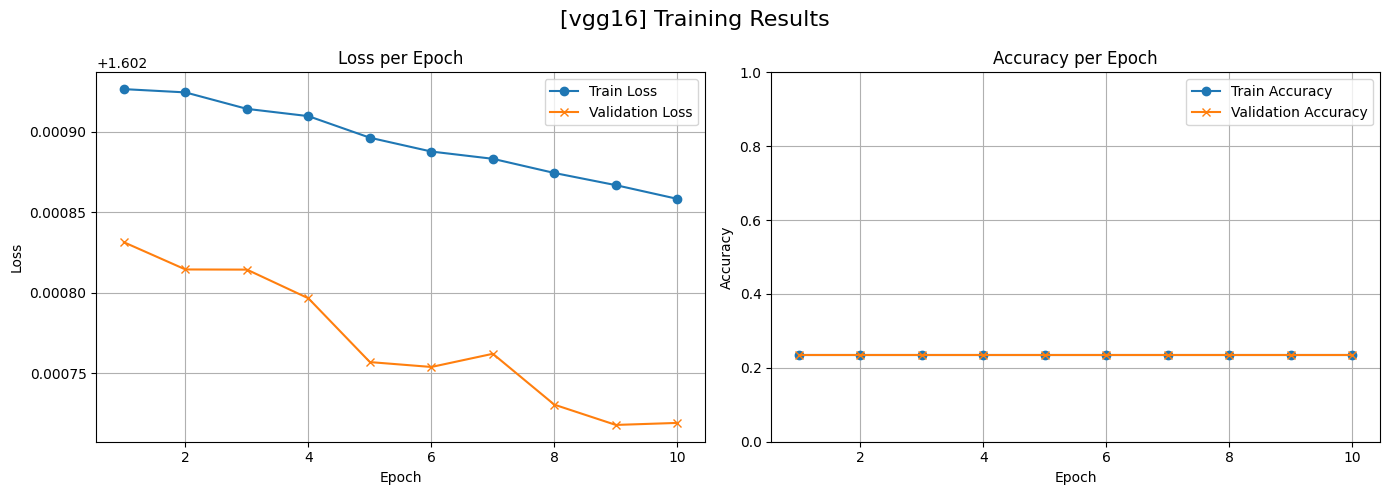

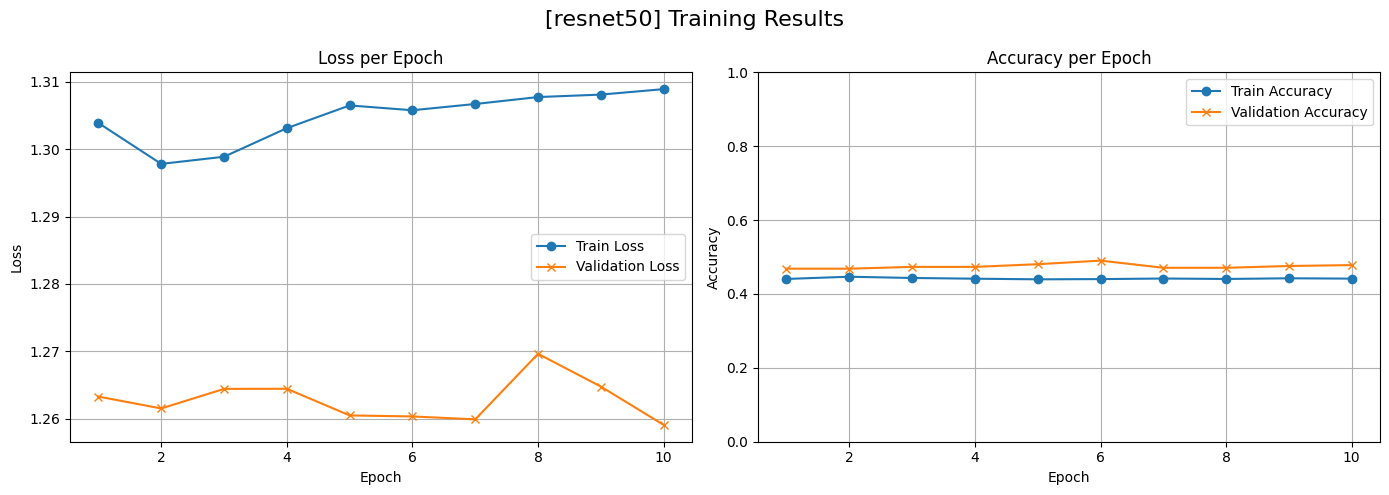

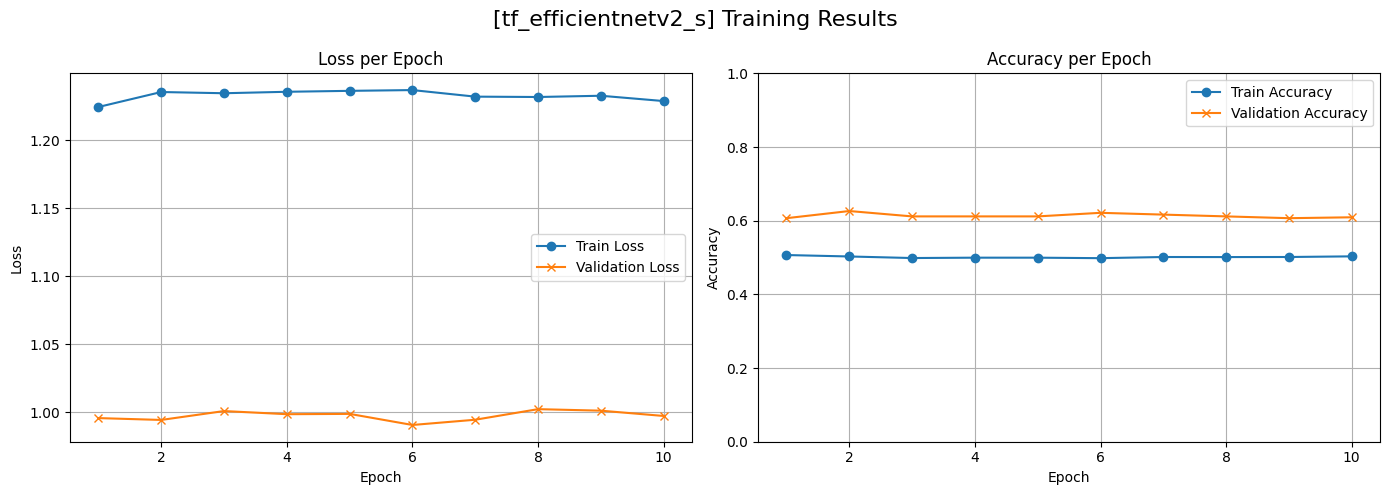

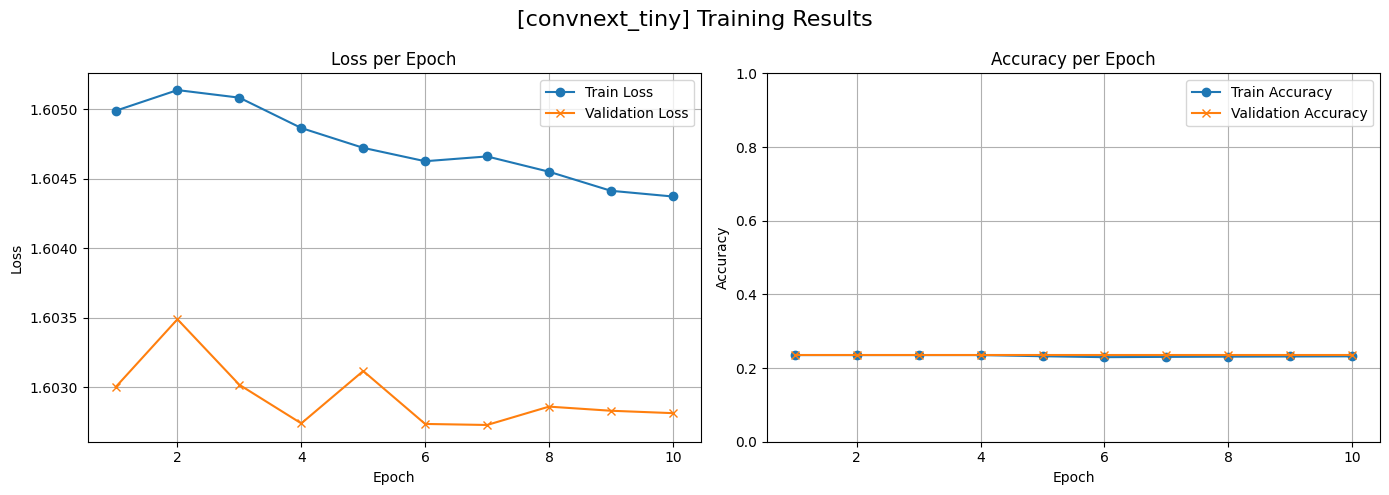

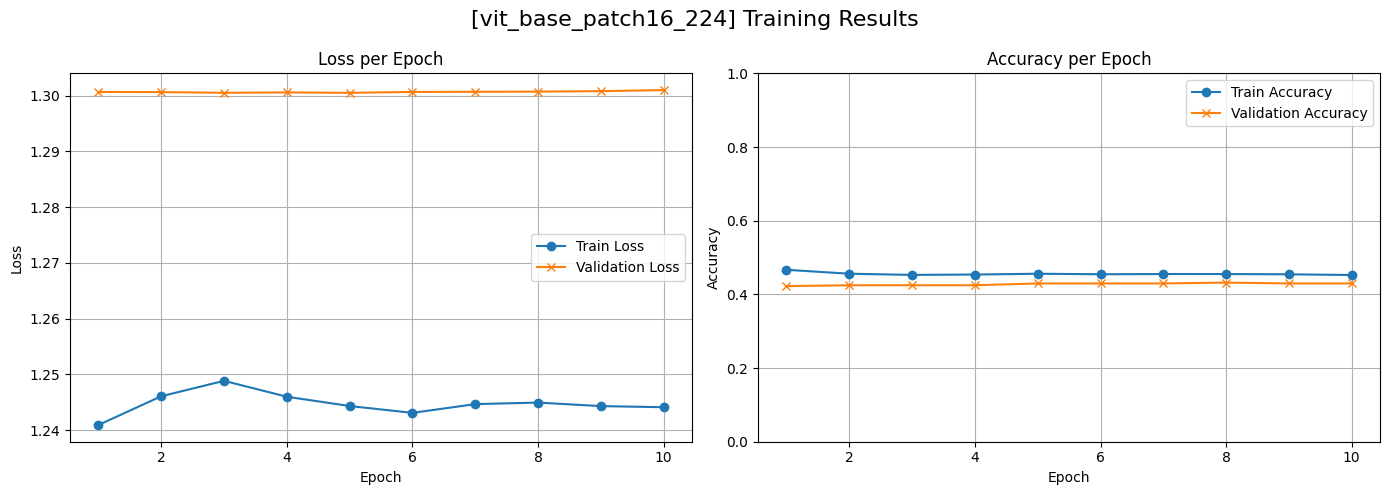

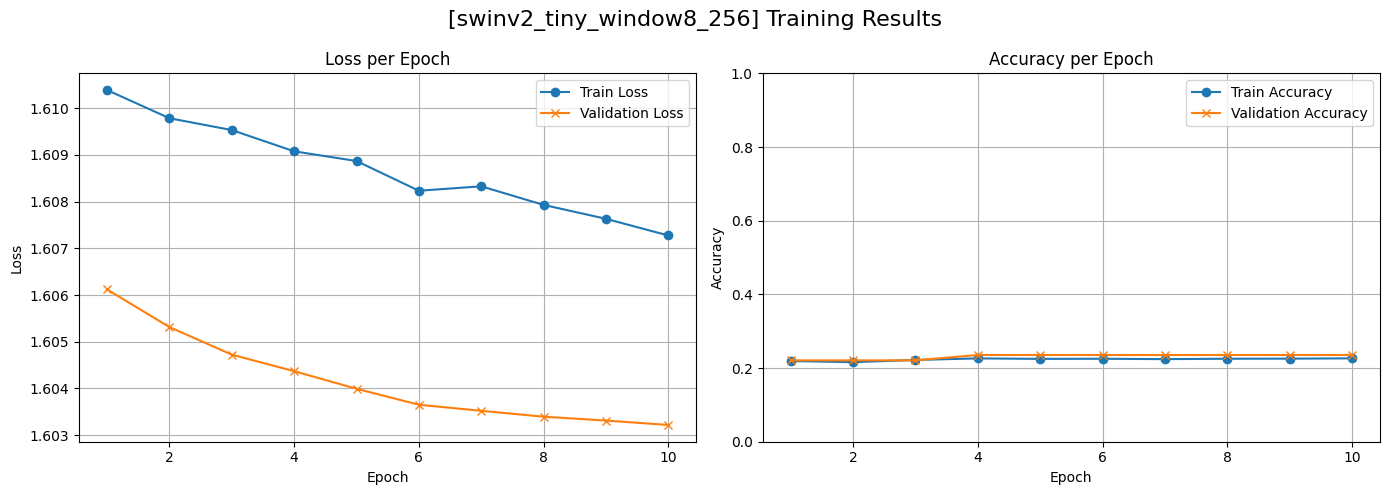

In [41]:
import matplotlib.pyplot as plt

def display_training_results(model):
    """
    train_logs가 list[dict] 형태일 때, Loss/Accuracy를 시각화
    - Loss는 자동 Y축
    - Accuracy는 Y축을 0.0~1.0으로 고정
    """

    logs = model.train_logs

    # 리스트에서 값 추출
    epochs = [log['epoch'] for log in logs]
    train_loss = [log['train_loss'] for log in logs]
    val_loss = [log['val_loss'] for log in logs]
    train_acc = [log['train_acc'] for log in logs]
    val_acc = [log['val_acc'] for log in logs]

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss (자동 스케일)
    axes[0].plot(epochs, train_loss, label='Train Loss', marker='o')
    axes[0].plot(epochs, val_loss, label='Validation Loss', marker='x')
    axes[0].set_title('Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy (0.0 ~ 1.0 고정)
    axes[1].plot(epochs, train_acc, label='Train Accuracy', marker='o')
    axes[1].plot(epochs, val_acc, label='Validation Accuracy', marker='x')
    axes[1].set_title('Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim([0.0, 1.0])
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle(f"[{model.model_name}] Training Results", fontsize=16)
    plt.tight_layout()
    plt.show()

for model in imageClassificationModels:
    display_training_results(model)

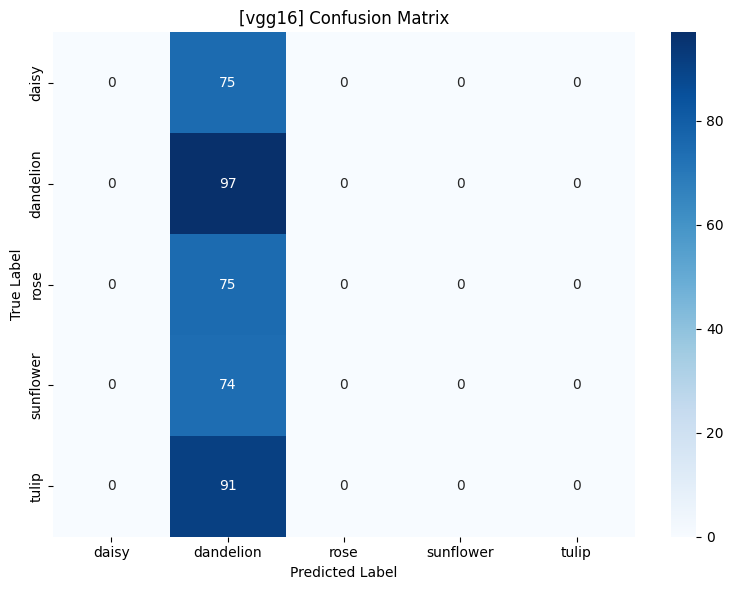


📊 [vgg16] Performance Metrics
Accuracy : 0.2354
Precision: 0.0554
Recall   : 0.2354
F1 Score : 0.0897

📋 Classification Report
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        75
   dandelion       0.24      1.00      0.38        97
        rose       0.00      0.00      0.00        75
   sunflower       0.00      0.00      0.00        74
       tulip       0.00      0.00      0.00        91

    accuracy                           0.24       412
   macro avg       0.05      0.20      0.08       412
weighted avg       0.06      0.24      0.09       412



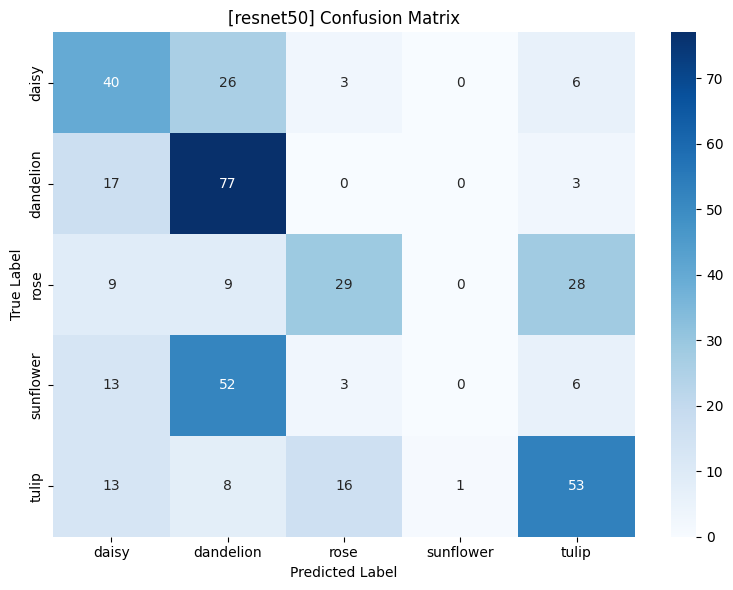


📊 [resnet50] Performance Metrics
Accuracy : 0.4830
Precision: 0.4100
Recall   : 0.4830
F1 Score : 0.4310

📋 Classification Report
              precision    recall  f1-score   support

       daisy       0.43      0.53      0.48        75
   dandelion       0.45      0.79      0.57        97
        rose       0.57      0.39      0.46        75
   sunflower       0.00      0.00      0.00        74
       tulip       0.55      0.58      0.57        91

    accuracy                           0.48       412
   macro avg       0.40      0.46      0.42       412
weighted avg       0.41      0.48      0.43       412



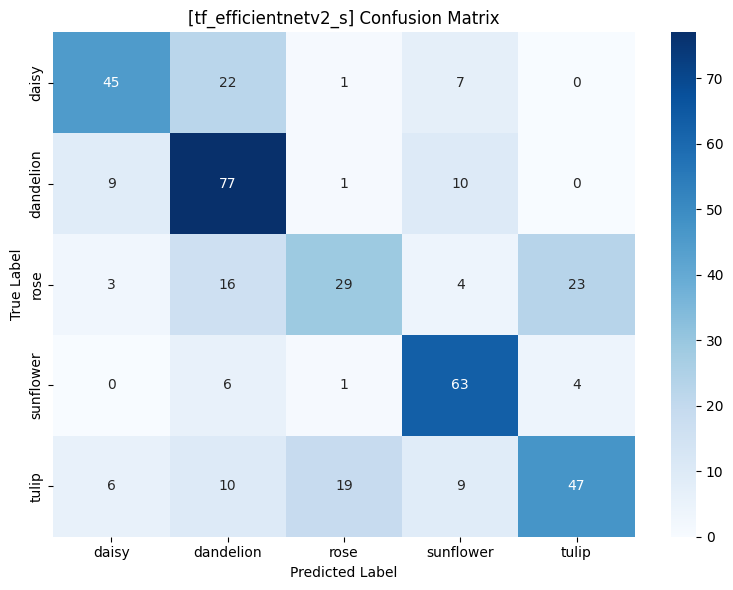


📊 [tf_efficientnetv2_s] Performance Metrics
Accuracy : 0.6335
Precision: 0.6339
Recall   : 0.6335
F1 Score : 0.6229

📋 Classification Report
              precision    recall  f1-score   support

       daisy       0.71      0.60      0.65        75
   dandelion       0.59      0.79      0.68        97
        rose       0.57      0.39      0.46        75
   sunflower       0.68      0.85      0.75        74
       tulip       0.64      0.52      0.57        91

    accuracy                           0.63       412
   macro avg       0.64      0.63      0.62       412
weighted avg       0.63      0.63      0.62       412



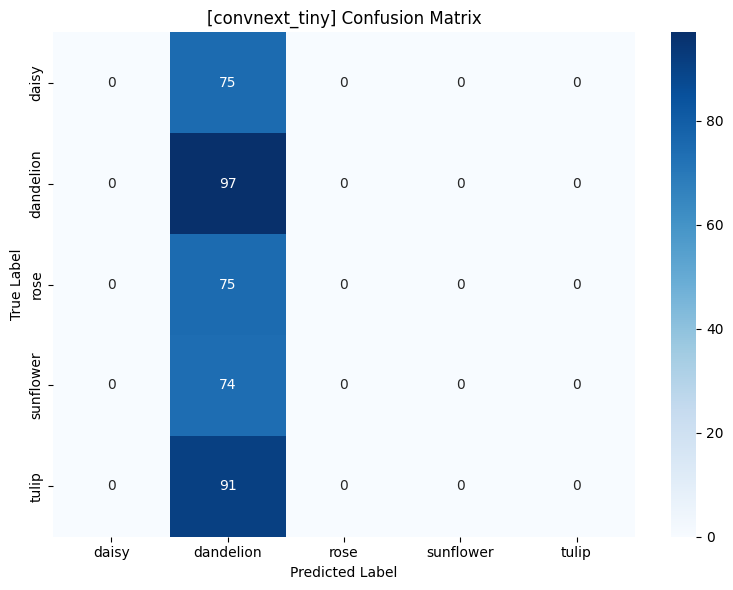


📊 [convnext_tiny] Performance Metrics
Accuracy : 0.2354
Precision: 0.0554
Recall   : 0.2354
F1 Score : 0.0897

📋 Classification Report
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        75
   dandelion       0.24      1.00      0.38        97
        rose       0.00      0.00      0.00        75
   sunflower       0.00      0.00      0.00        74
       tulip       0.00      0.00      0.00        91

    accuracy                           0.24       412
   macro avg       0.05      0.20      0.08       412
weighted avg       0.06      0.24      0.09       412



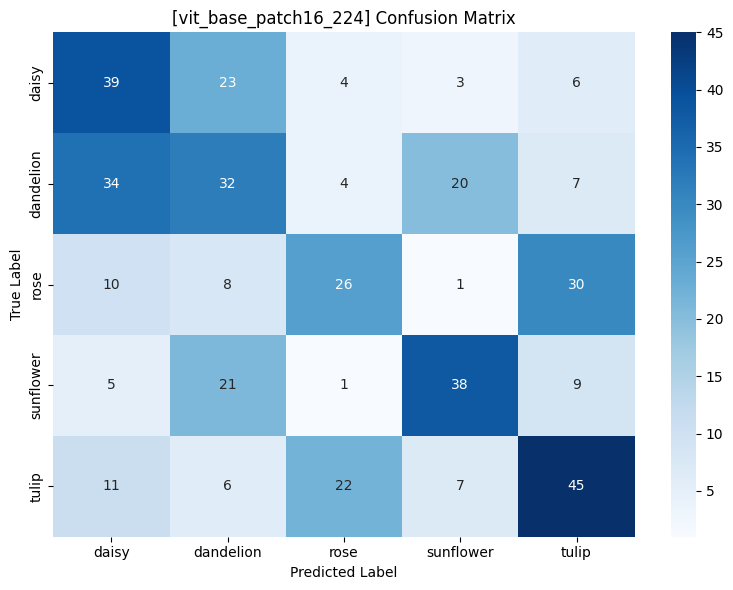


📊 [vit_base_patch16_224] Performance Metrics
Accuracy : 0.4369
Precision: 0.4398
Recall   : 0.4369
F1 Score : 0.4351

📋 Classification Report
              precision    recall  f1-score   support

       daisy       0.39      0.52      0.45        75
   dandelion       0.36      0.33      0.34        97
        rose       0.46      0.35      0.39        75
   sunflower       0.55      0.51      0.53        74
       tulip       0.46      0.49      0.48        91

    accuracy                           0.44       412
   macro avg       0.44      0.44      0.44       412
weighted avg       0.44      0.44      0.44       412



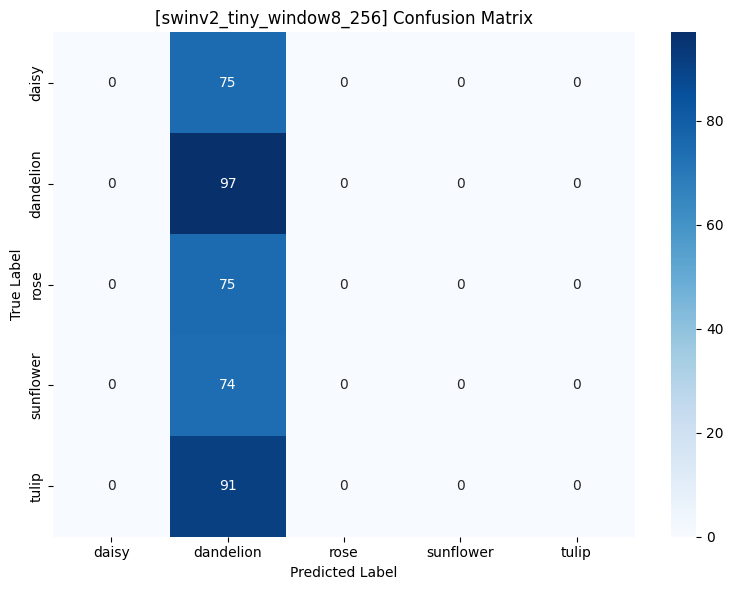


📊 [swinv2_tiny_window8_256] Performance Metrics
Accuracy : 0.2354
Precision: 0.0554
Recall   : 0.2354
F1 Score : 0.0897

📋 Classification Report
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        75
   dandelion       0.24      1.00      0.38        97
        rose       0.00      0.00      0.00        75
   sunflower       0.00      0.00      0.00        74
       tulip       0.00      0.00      0.00        91

    accuracy                           0.24       412
   macro avg       0.05      0.20      0.08       412
weighted avg       0.06      0.24      0.09       412



In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_performance(model: ImageClassificationModel, class_names=None):
    """
    Confusion Matrix + Classification Report 시각화
    - model.test_all_preds, model.test_all_targets 기반
    """
    preds = model.test_all_preds
    targets = model.test_all_targets

    if not preds or not targets:
        print(f"[{model.model_name}] 평가 지표 시각화를 위한 데이터가 없습니다.")
        return

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    num_classes = model.num_classes

    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"[{model.model_name}] Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Accuracy, Precision, Recall, F1
    acc = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average='weighted', zero_division=0)
    recall = recall_score(targets, preds, average='weighted', zero_division=0)
    f1 = f1_score(targets, preds, average='weighted', zero_division=0)

    print(f"\n📊 [{model.model_name}] Performance Metrics")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Classification Report
    print("\n📋 Classification Report")
    print(classification_report(targets, preds, target_names=class_names, zero_division=0))

class_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
for model in imageClassificationModels:
    visualize_model_performance(model, class_names=class_names)
